In [1]:
import tensorflow as tf
from modules.dataset import Dataset

2022-09-19 09:16:51.727183: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train, test = Dataset().get_kfold(1, sample=True)
test

2022-09-19 09:16:54.099971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 09:16:55.919136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32061 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:ca:00.0, compute capability: 8.0


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>

In [3]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

y_true = get_y_true(test)
y_true

<tf.Variable 'Variable:0' shape=(200, 15) dtype=int64, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])>

In [4]:
# Constant variables
# NAME = "ResNet50"
EPOCHS = 10
NUM_FOLDS = 5

dataset = Dataset()
fold_num = 1

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=True)

# Modeling
model = tf.keras.models.load_model("results/models/DenseNet121_fold1.h5")

In [5]:
y_preds = model.predict(test_dataset)

2022-09-19 09:17:07.836497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-19 09:17:09.145612: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-19 09:17:09.147036: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-19 09:17:09.147149: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-19 09:17:09.148504: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-19 09:17:09.148641: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      5/Unknown - 13s 40ms/step

2022-09-19 09:17:16.452842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 19s 482ms/step


In [6]:
threshold = 4
(y_preds > threshold).astype('int16')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [7]:
y_preds

array([[8.3600551e-01, 9.3995601e-02, 7.1217325e-03, ..., 3.5941344e-02,
        8.1315629e-02, 1.3422342e-04],
       [4.9758321e-01, 1.2788729e-01, 3.2319725e-02, ..., 4.8238579e-02,
        1.0488872e-01, 5.9208646e-03],
       [6.5601540e-01, 6.8769068e-02, 1.9325074e-02, ..., 4.6297722e-02,
        8.5738033e-02, 1.2605110e-03],
       ...,
       [8.3462590e-01, 6.3169234e-02, 6.2537282e-03, ..., 3.1199129e-02,
        7.5513937e-02, 6.5623142e-05],
       [6.4486378e-01, 1.3275596e-01, 2.6701592e-02, ..., 3.8579956e-02,
        1.2694345e-01, 3.0598422e-03],
       [6.3754827e-01, 9.2865117e-02, 2.5184222e-02, ..., 5.4138325e-02,
        9.7361177e-02, 2.2430087e-03]], dtype=float32)

In [8]:
m = tf.keras.metrics.AUC(multi_label=True)
m.update_state(y_true, y_preds)
m.result().numpy()

0.6319562

## Confusion metrics

In [9]:
thresholds = m._thresholds
thresholds[:5]

array([-1.00000000e-07,  5.02512563e-03,  1.00502513e-02,  1.50753769e-02,
        2.01005025e-02])

In [10]:
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    print(thresholds[i_thresh])
    for tp, tn, fp, fn in zip(tps, tns, fps, fns):
        print(tp, tn, fp, fn)
        break
    break

-1e-07
tf.Tensor(105.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(95.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [11]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

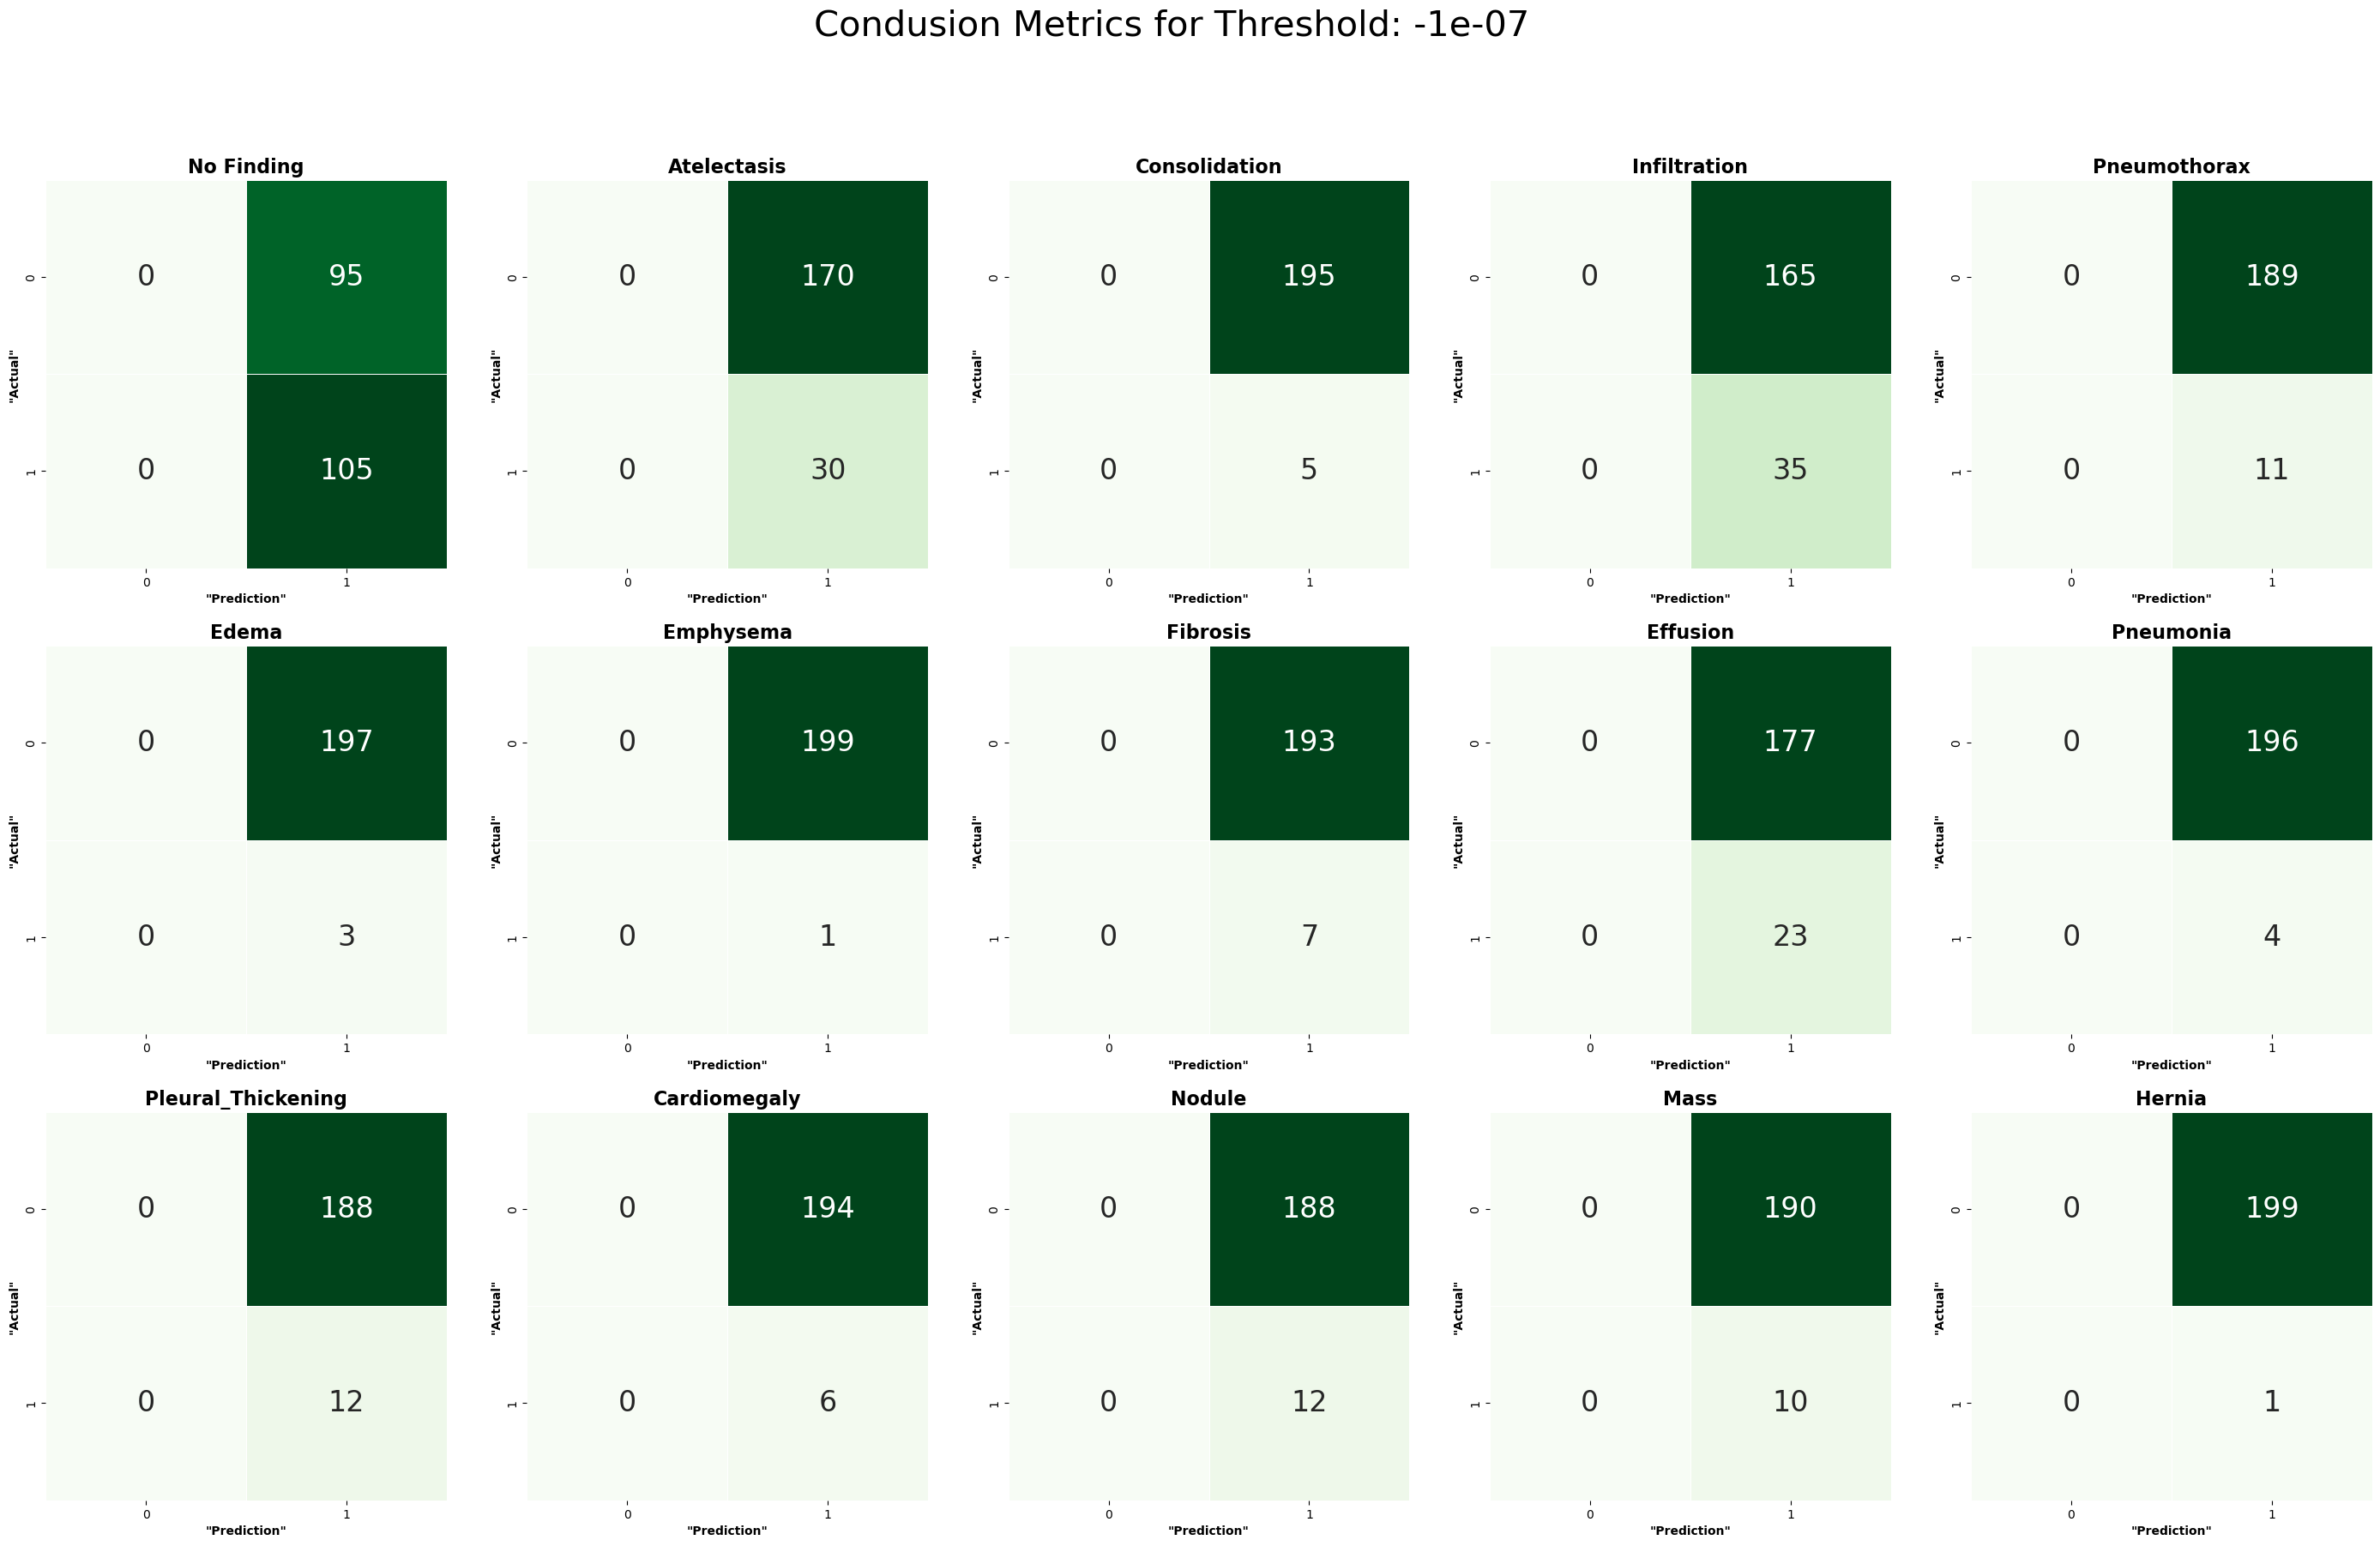

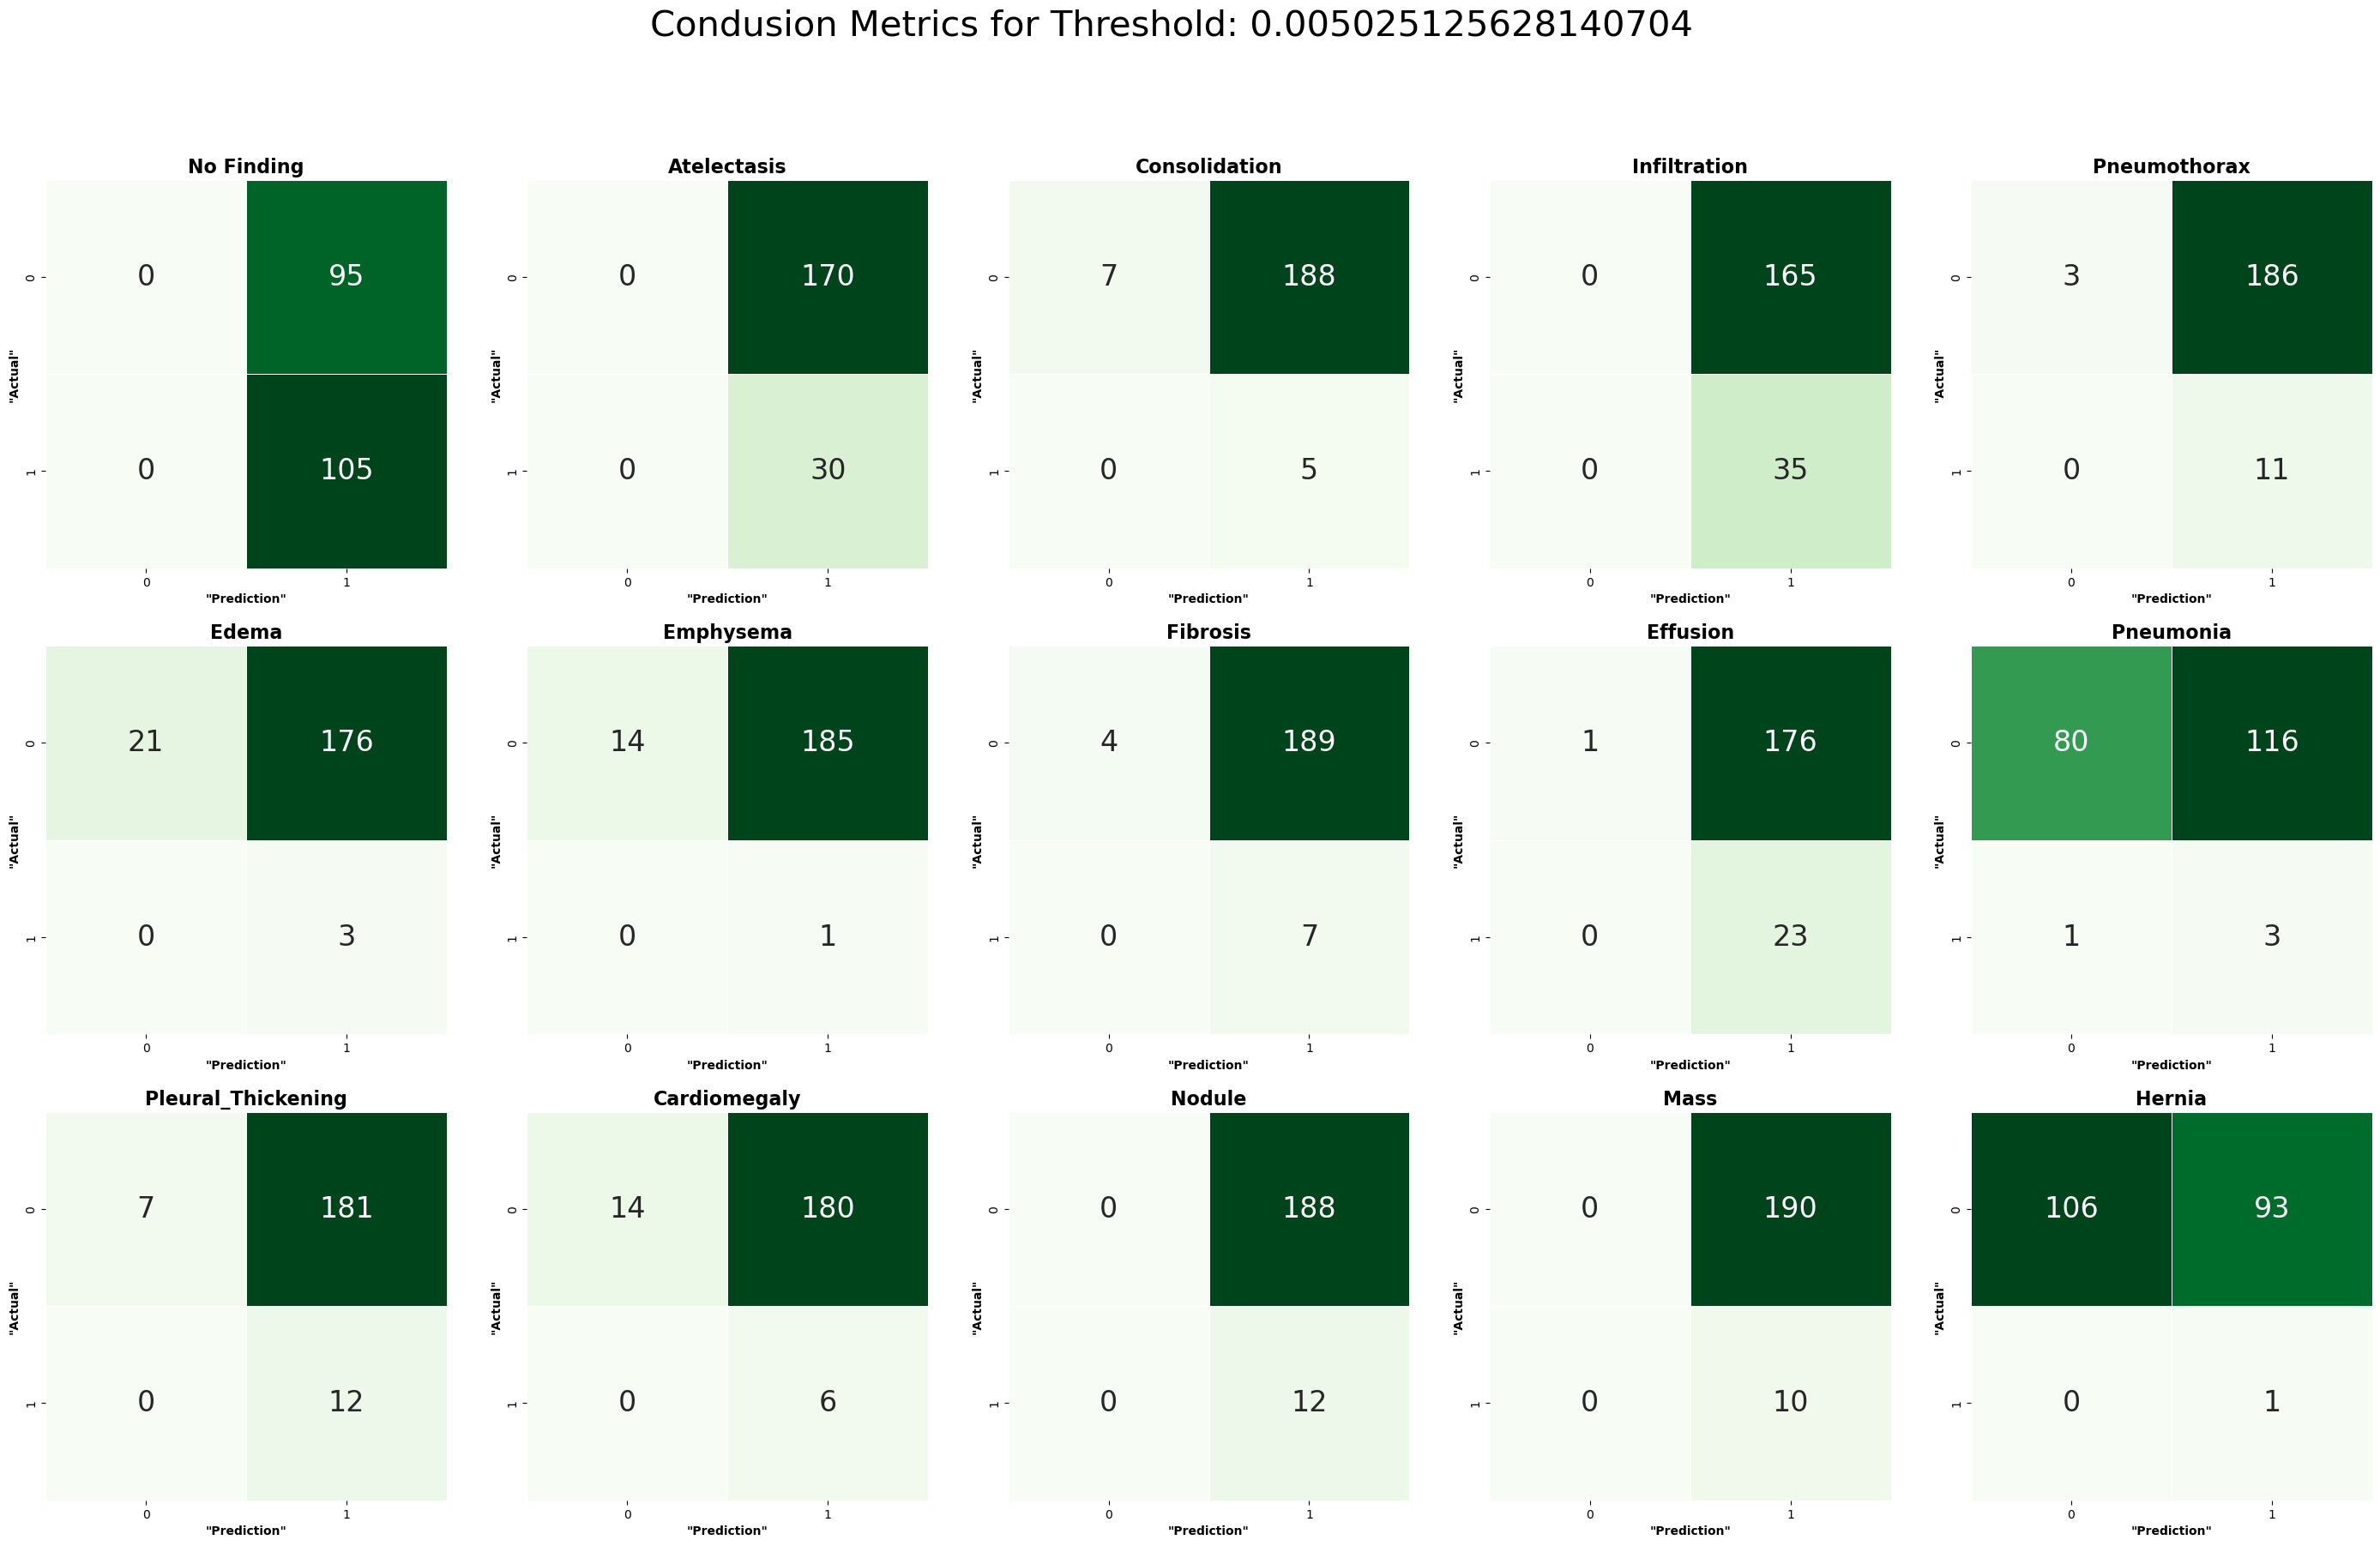

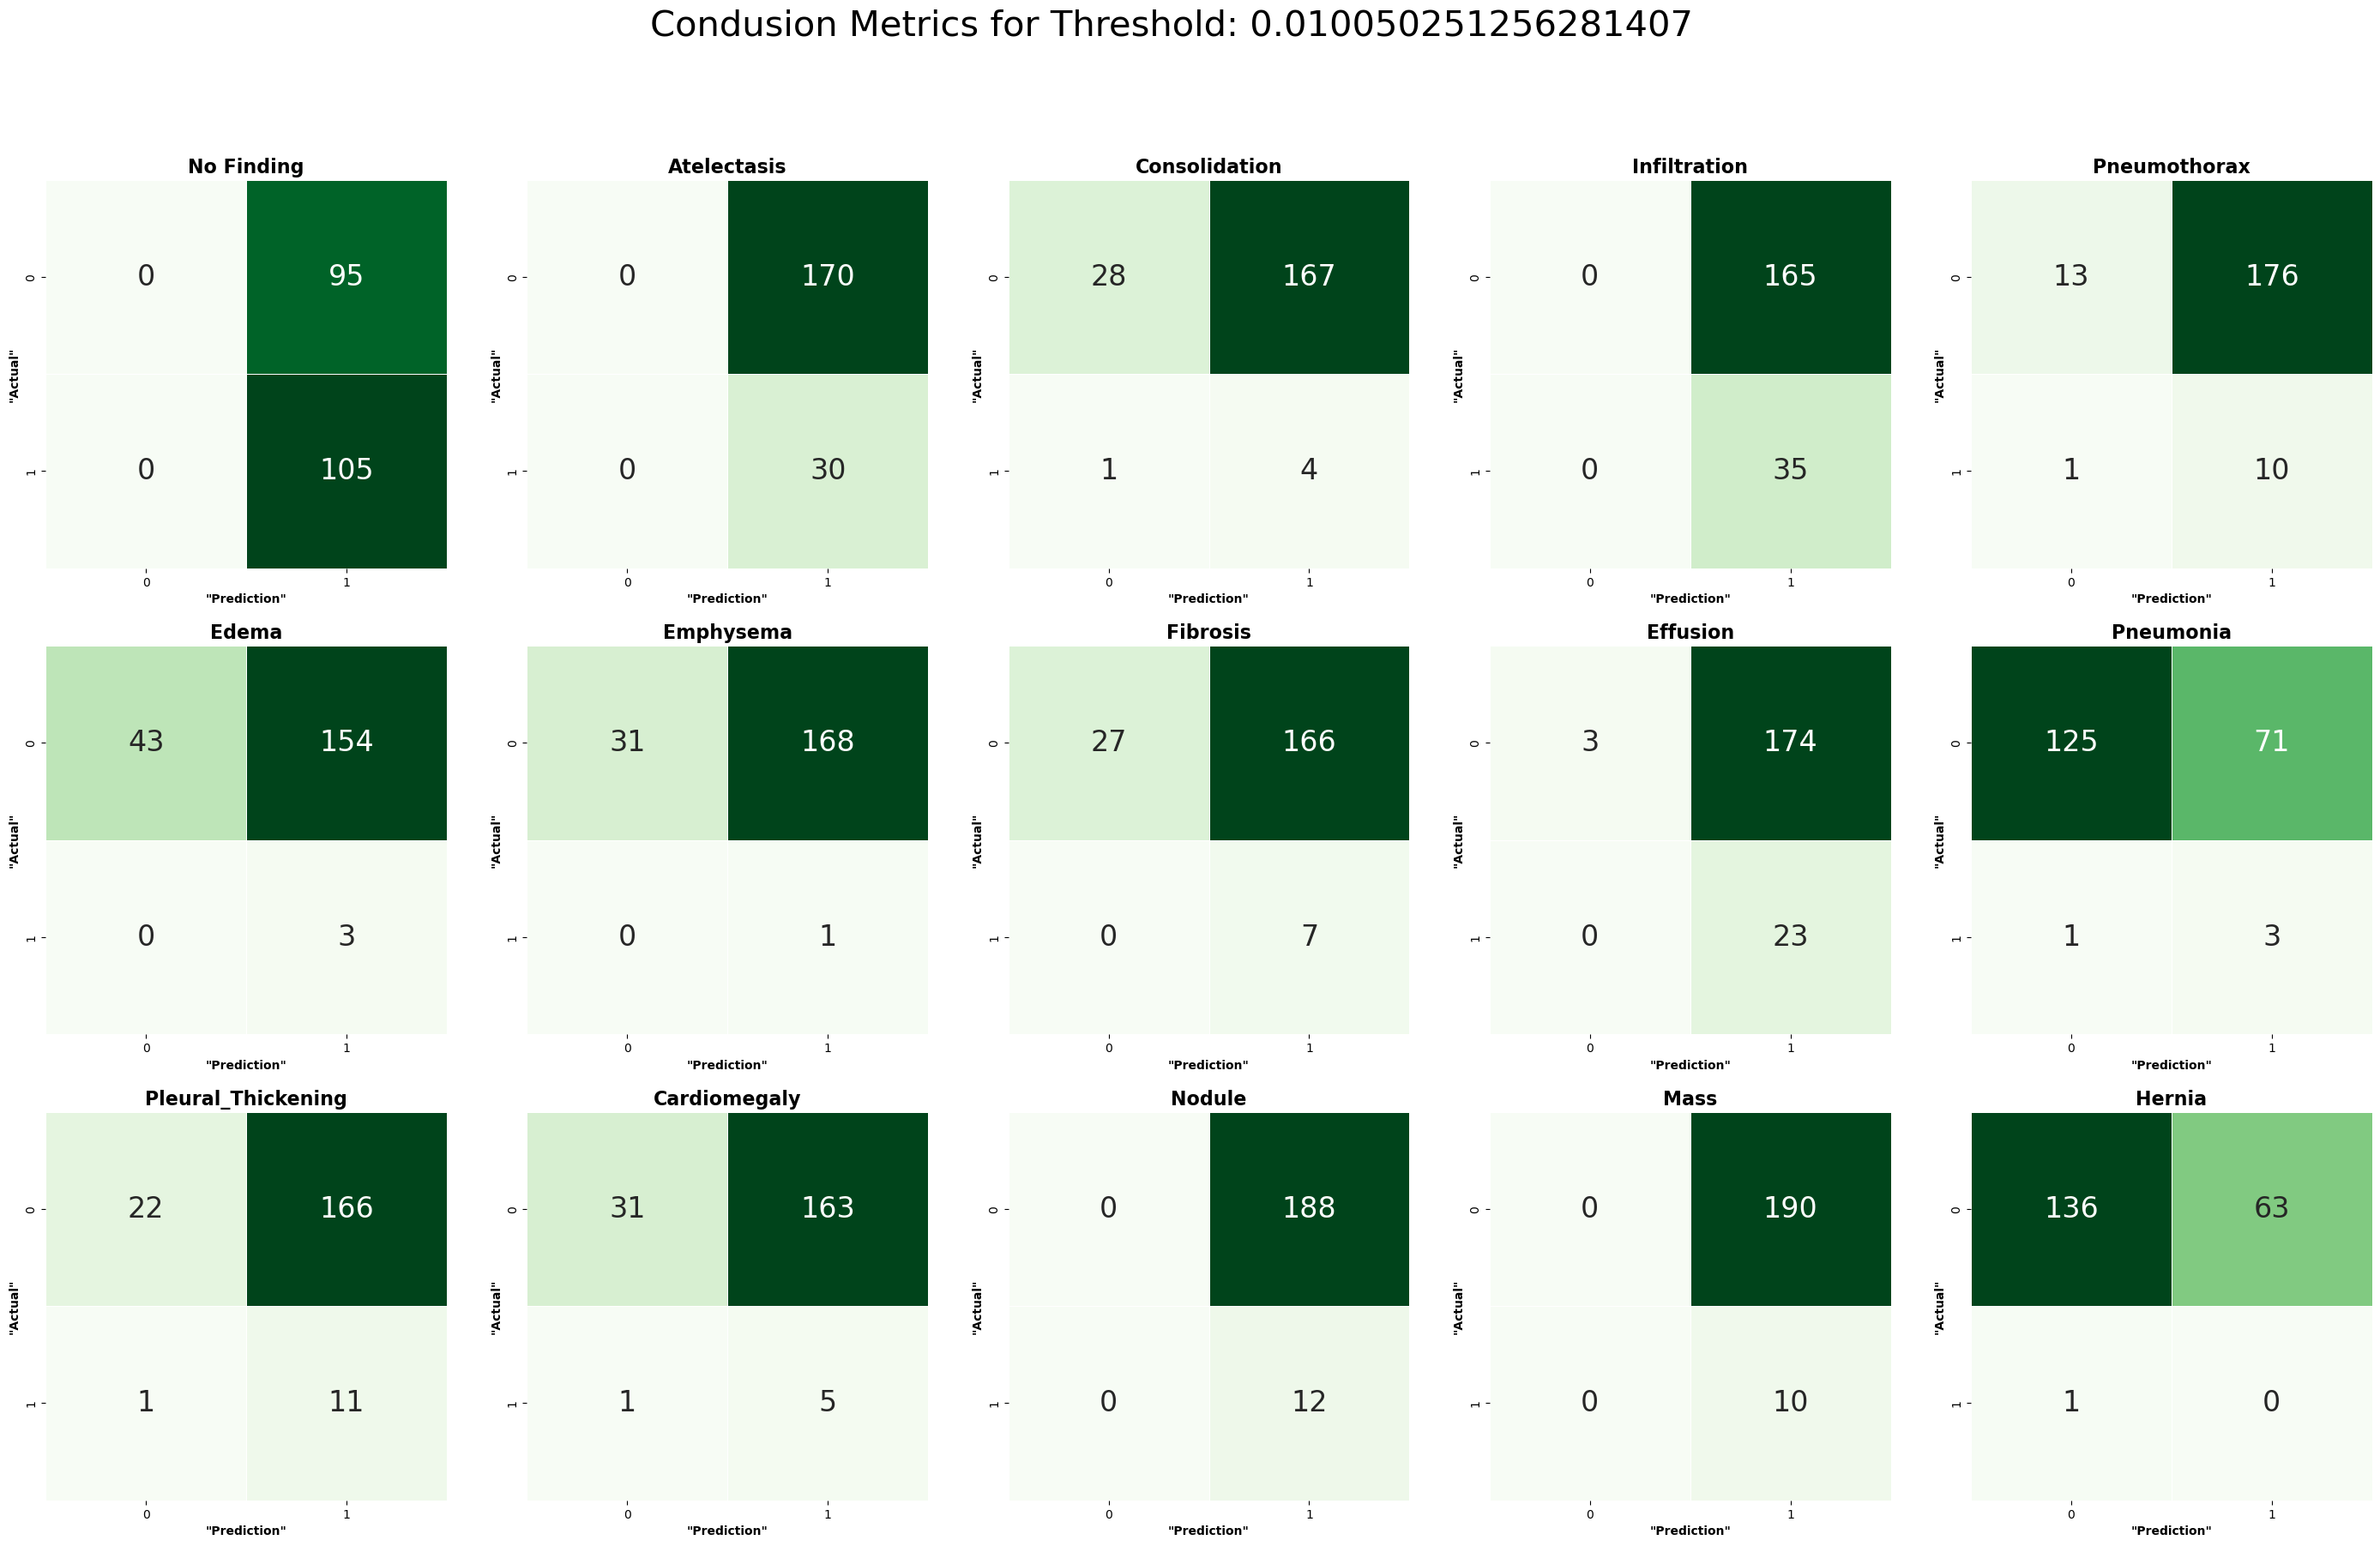

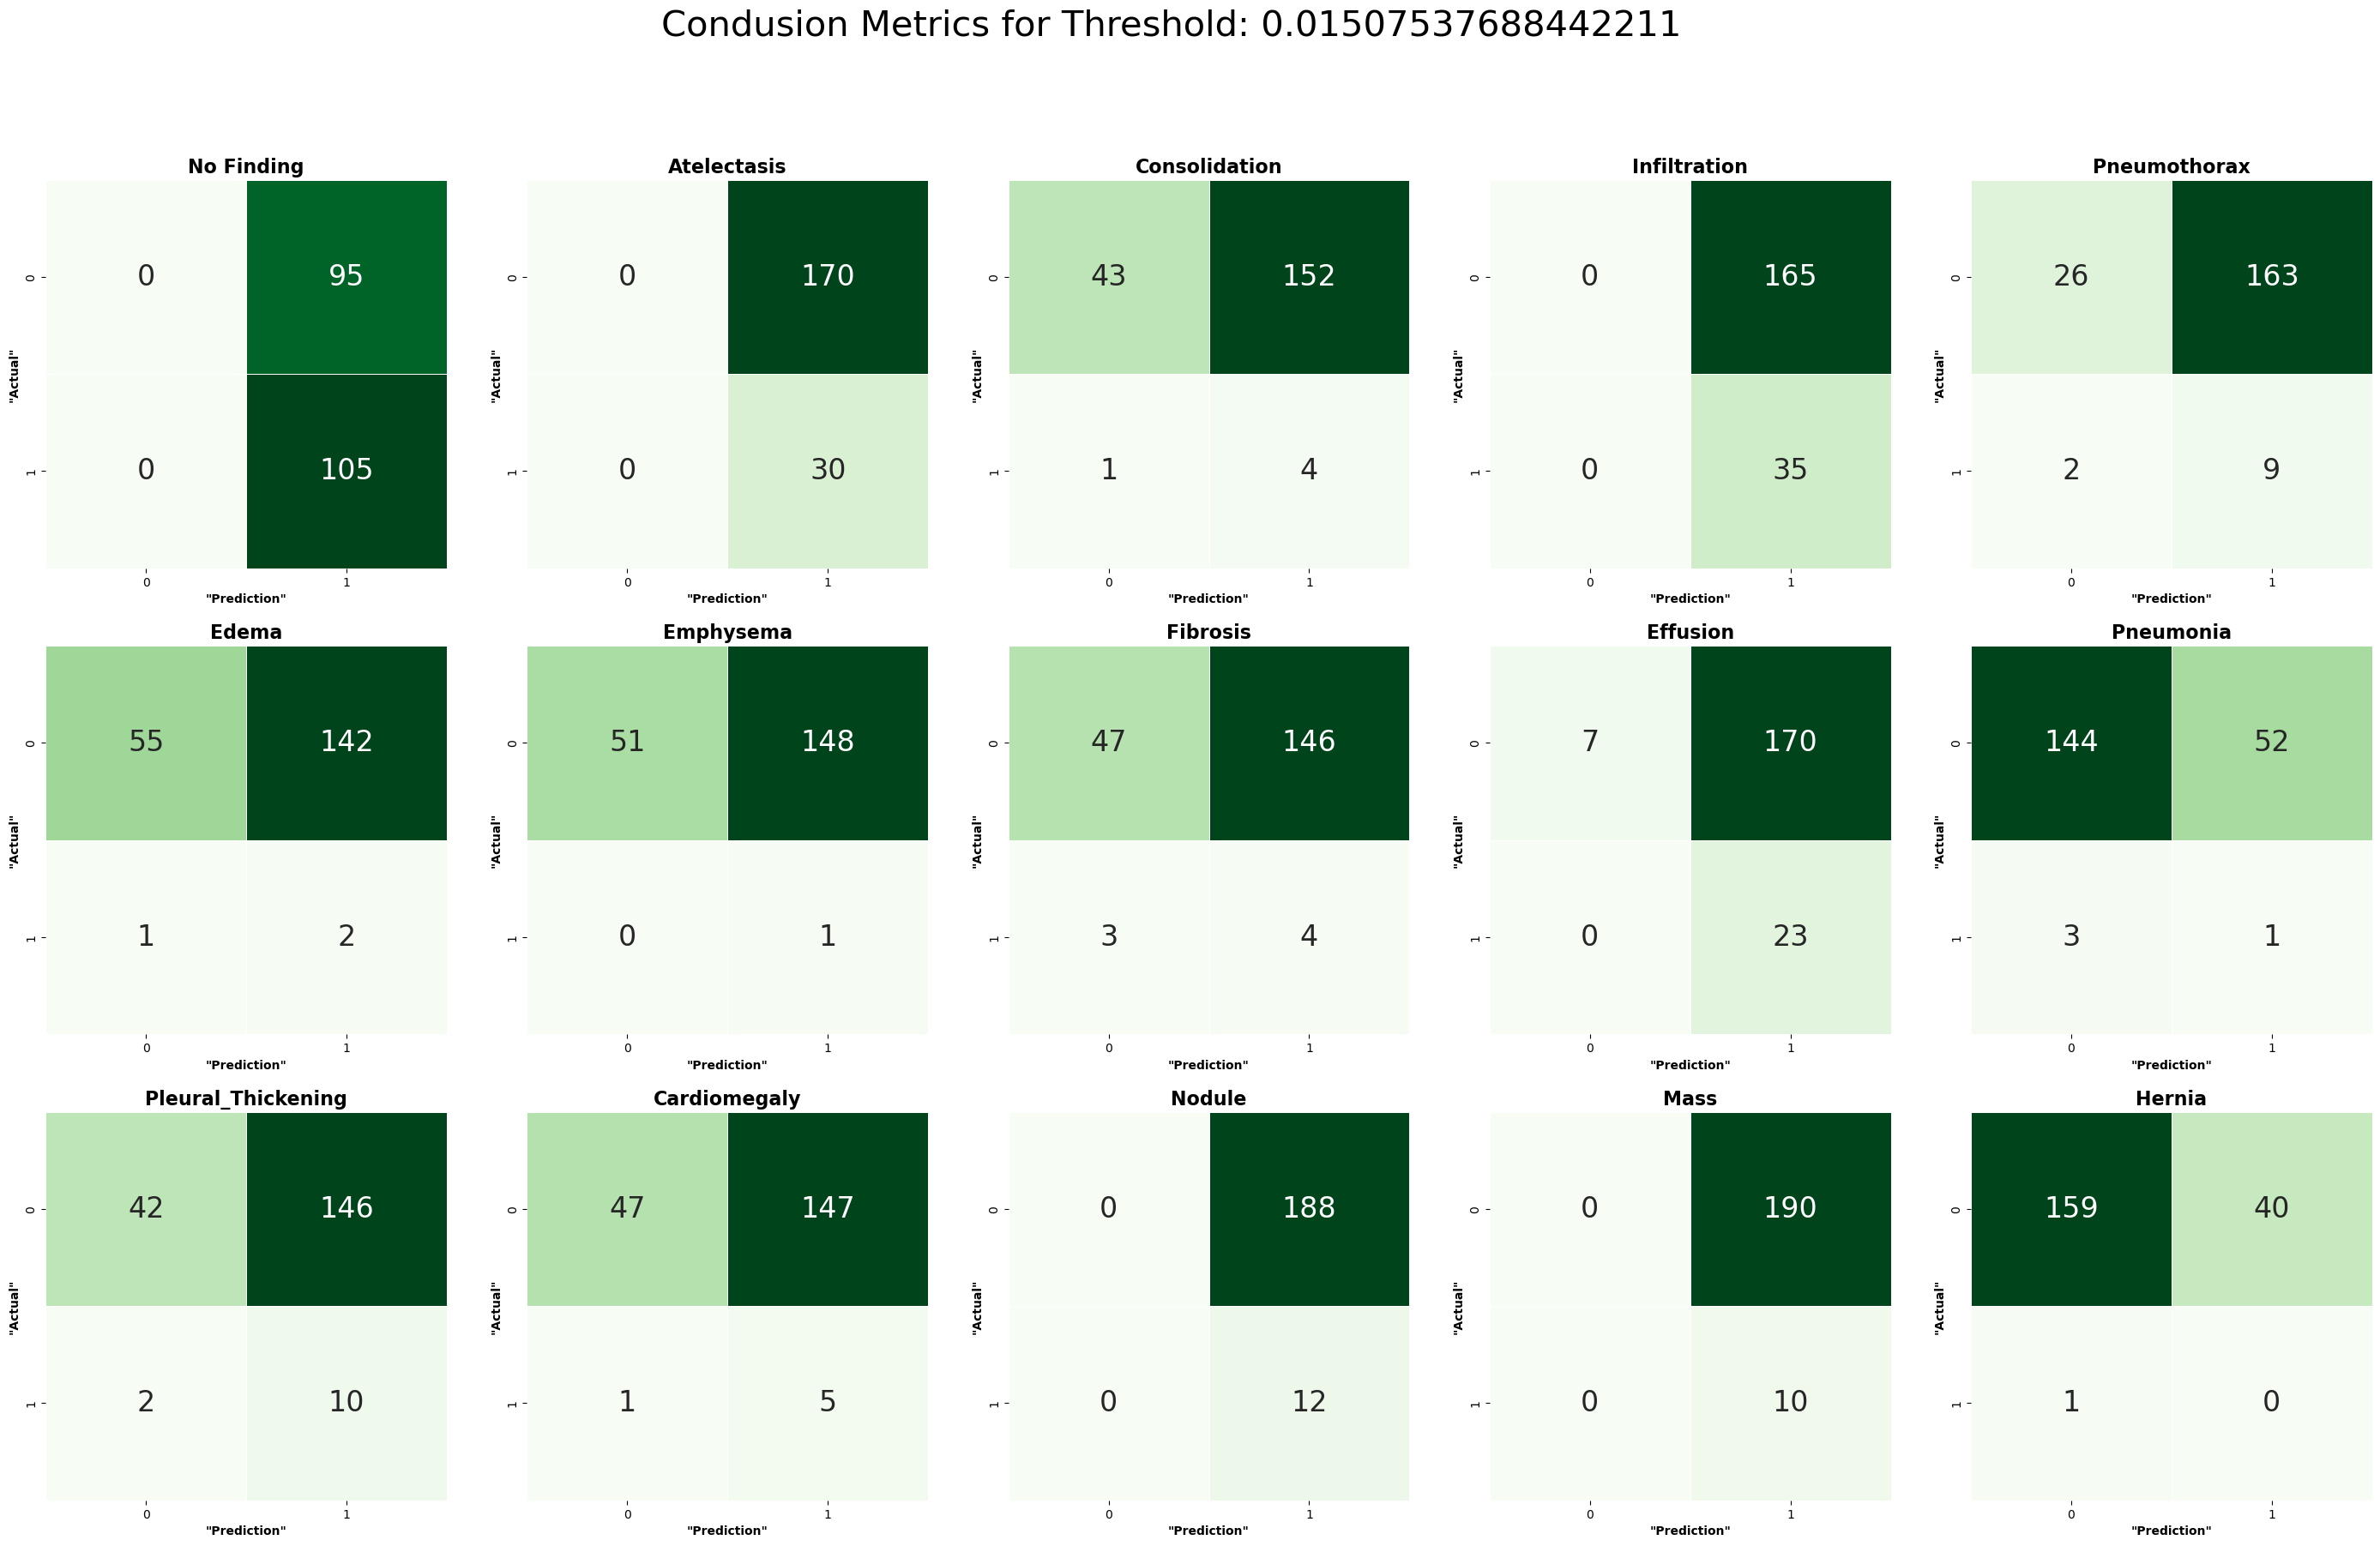

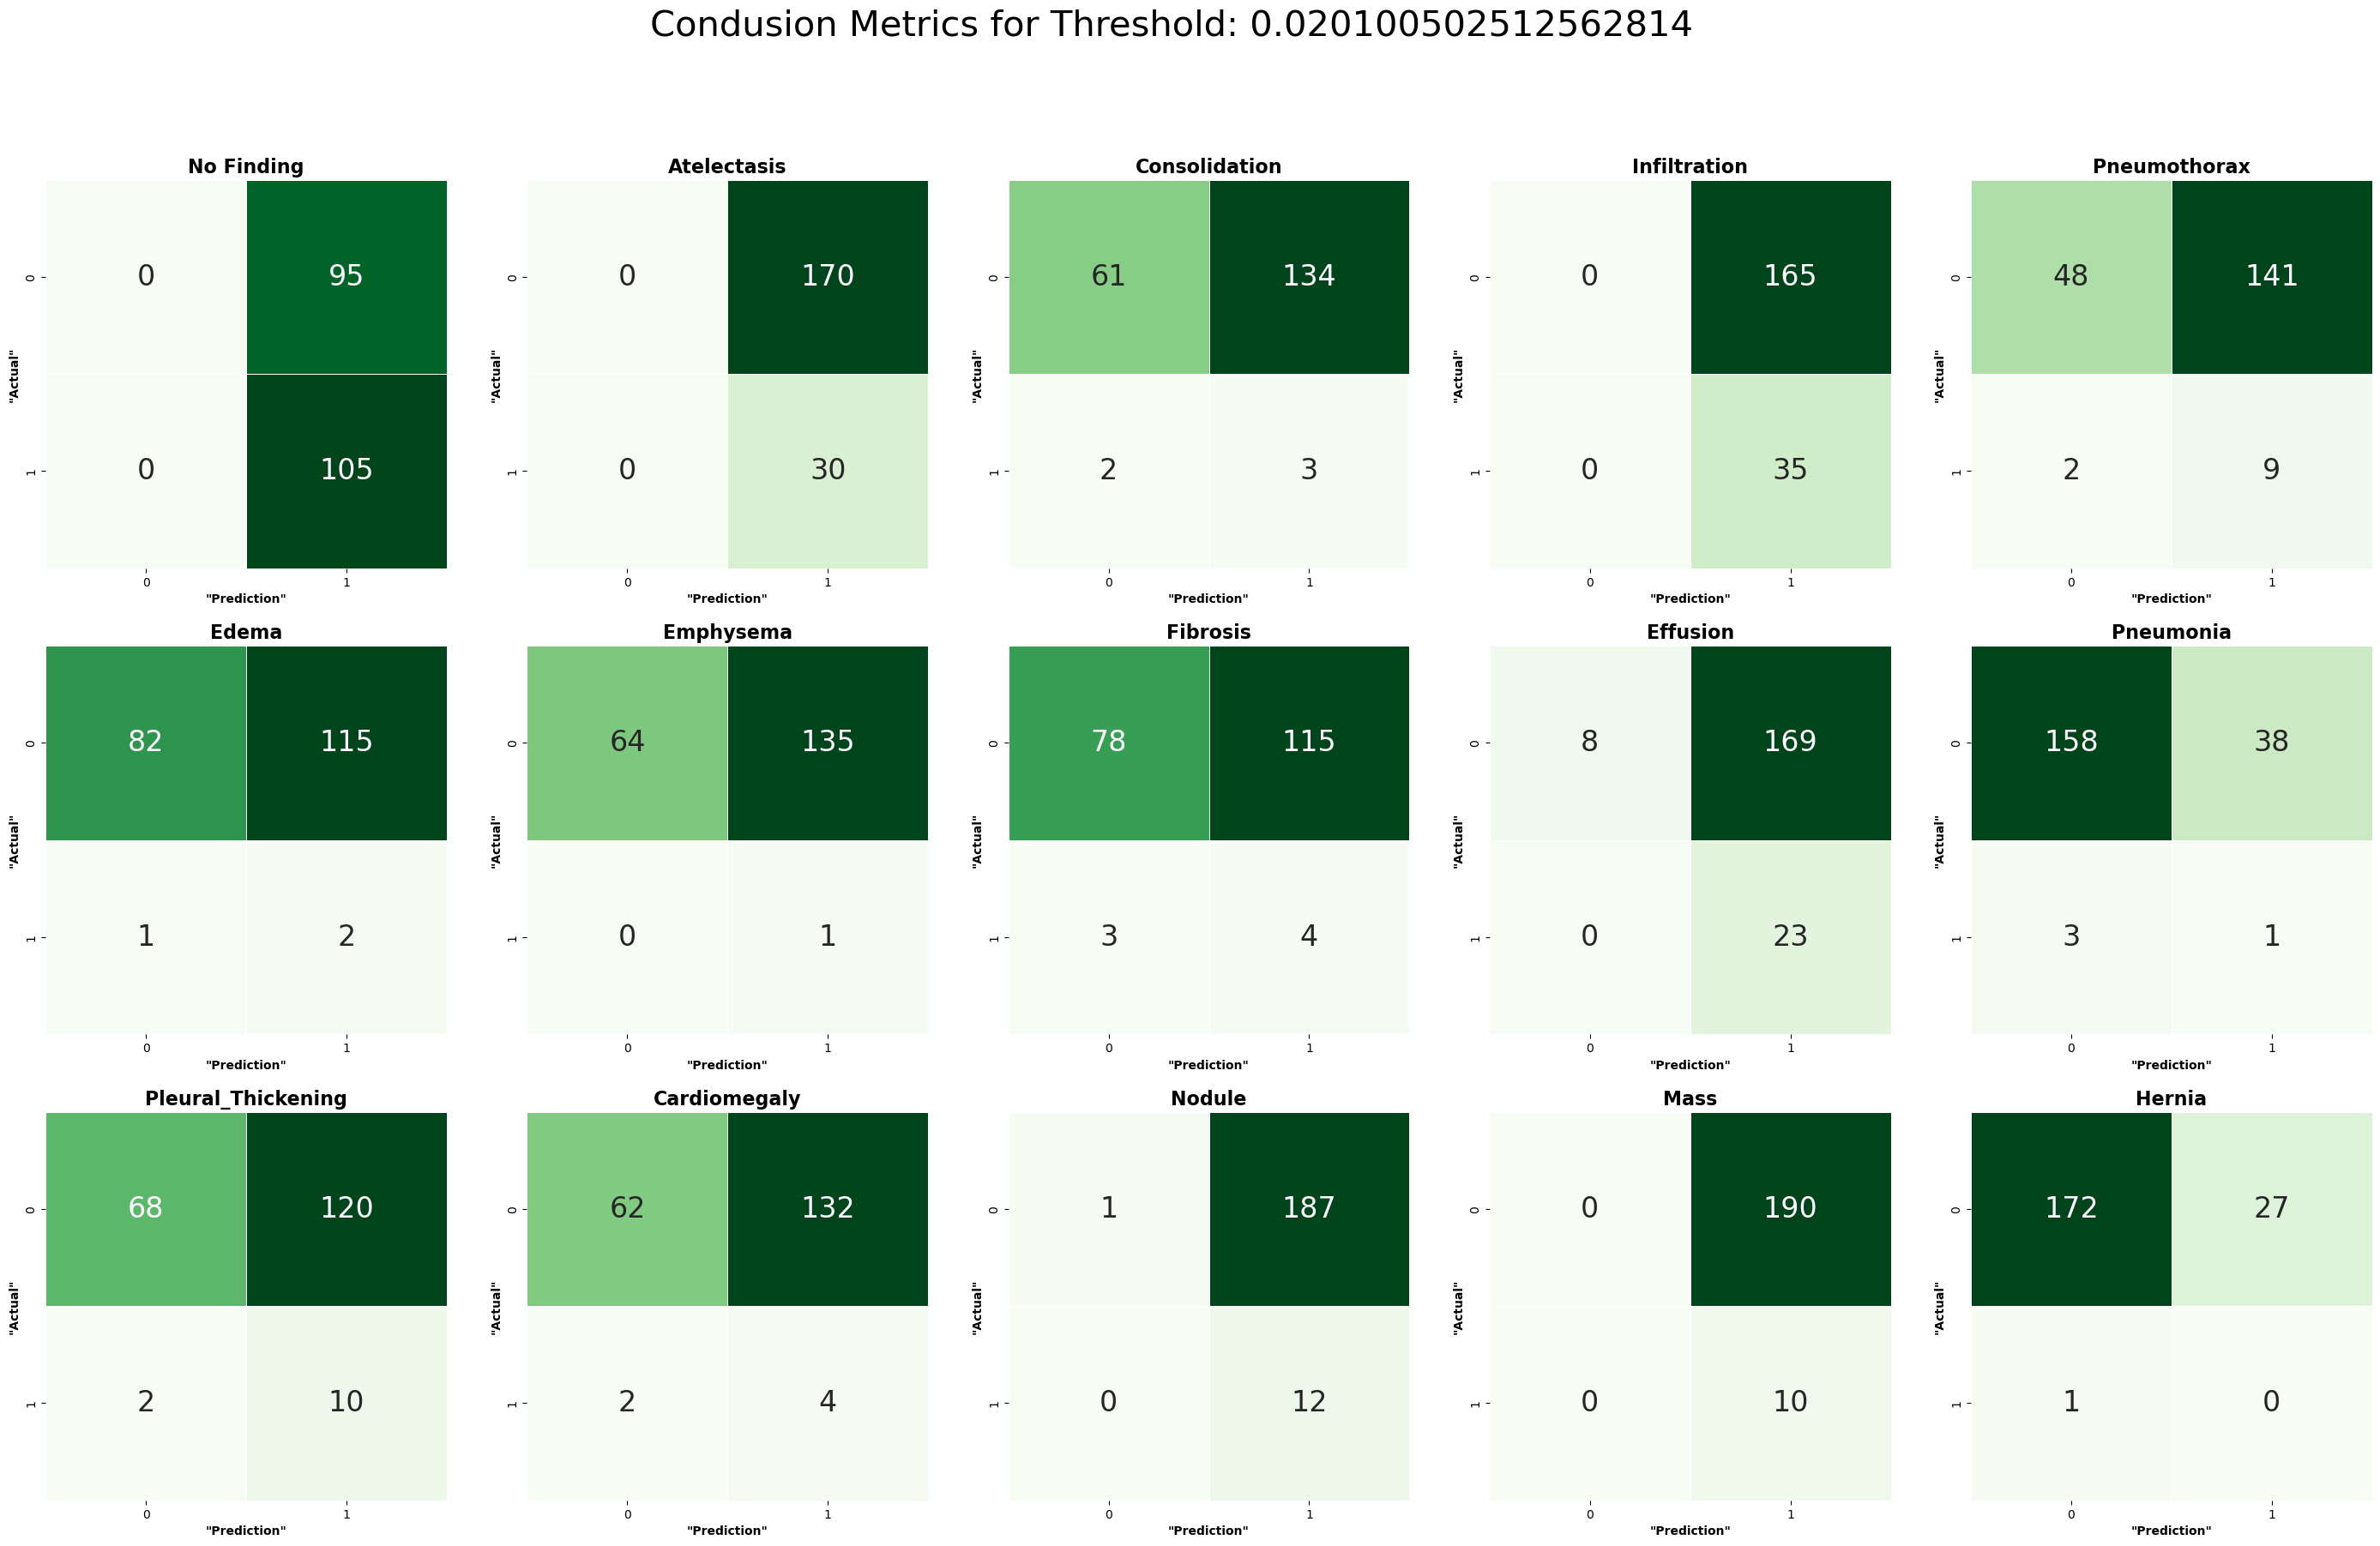

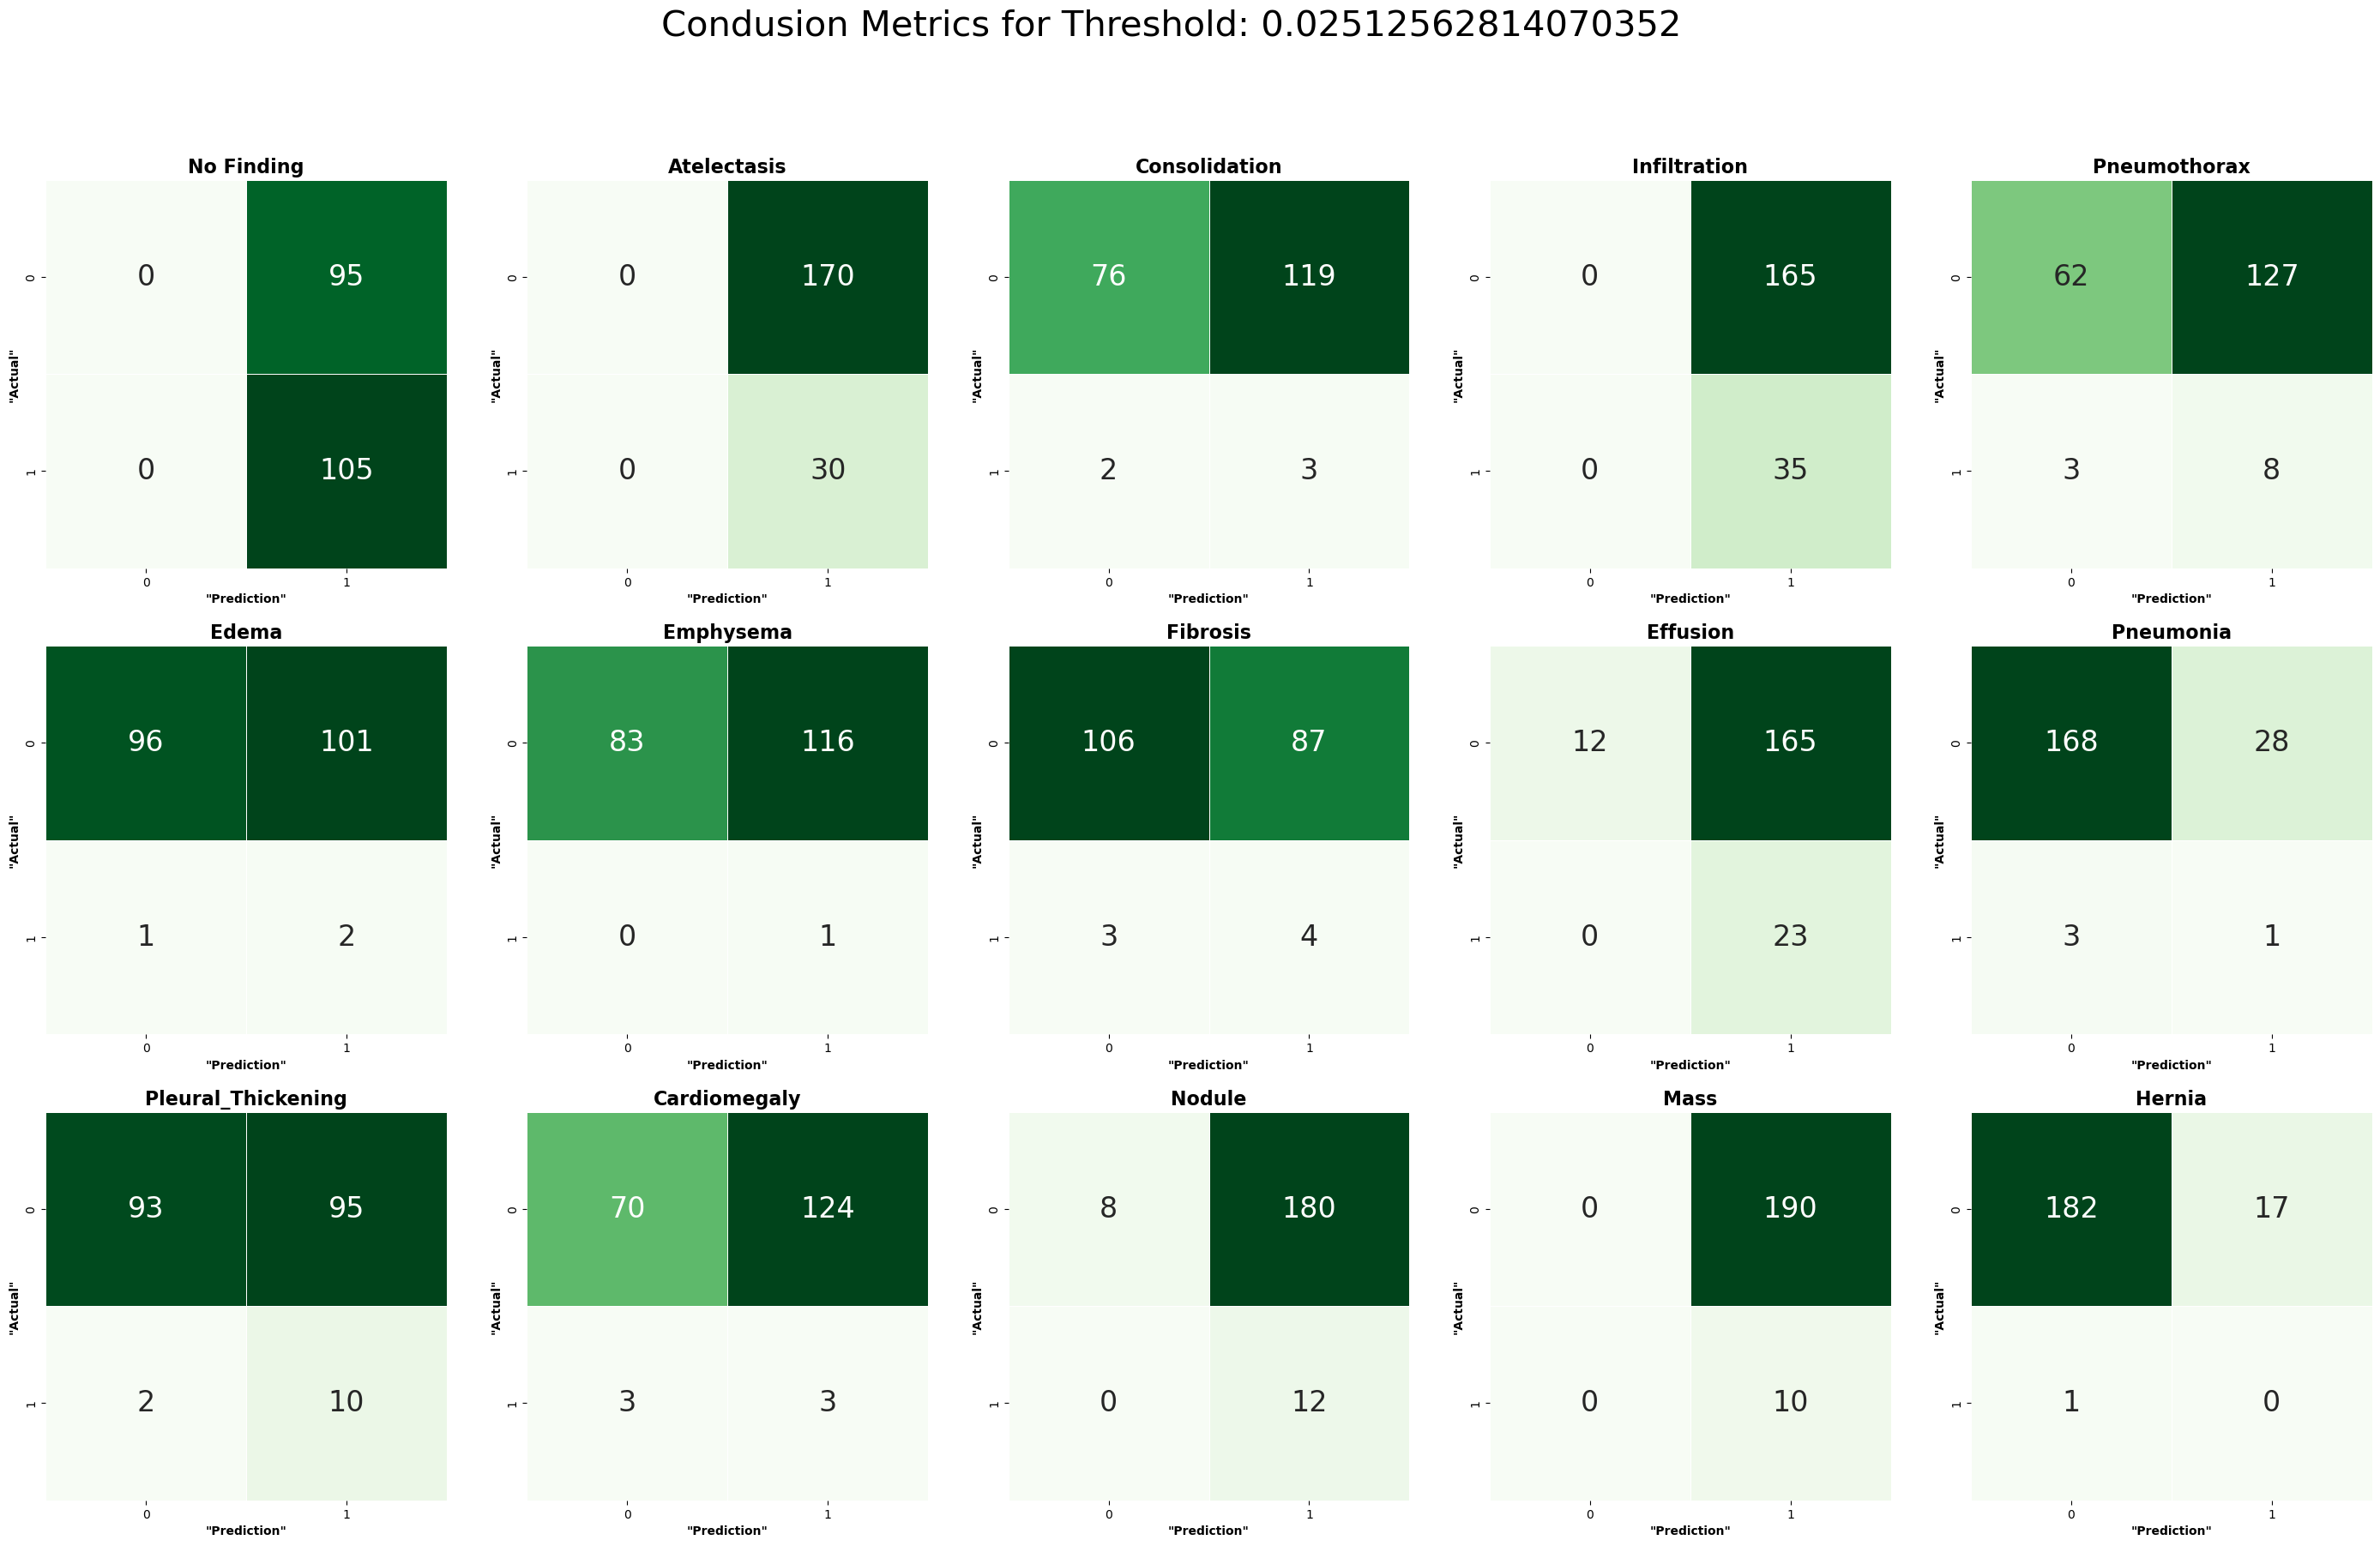

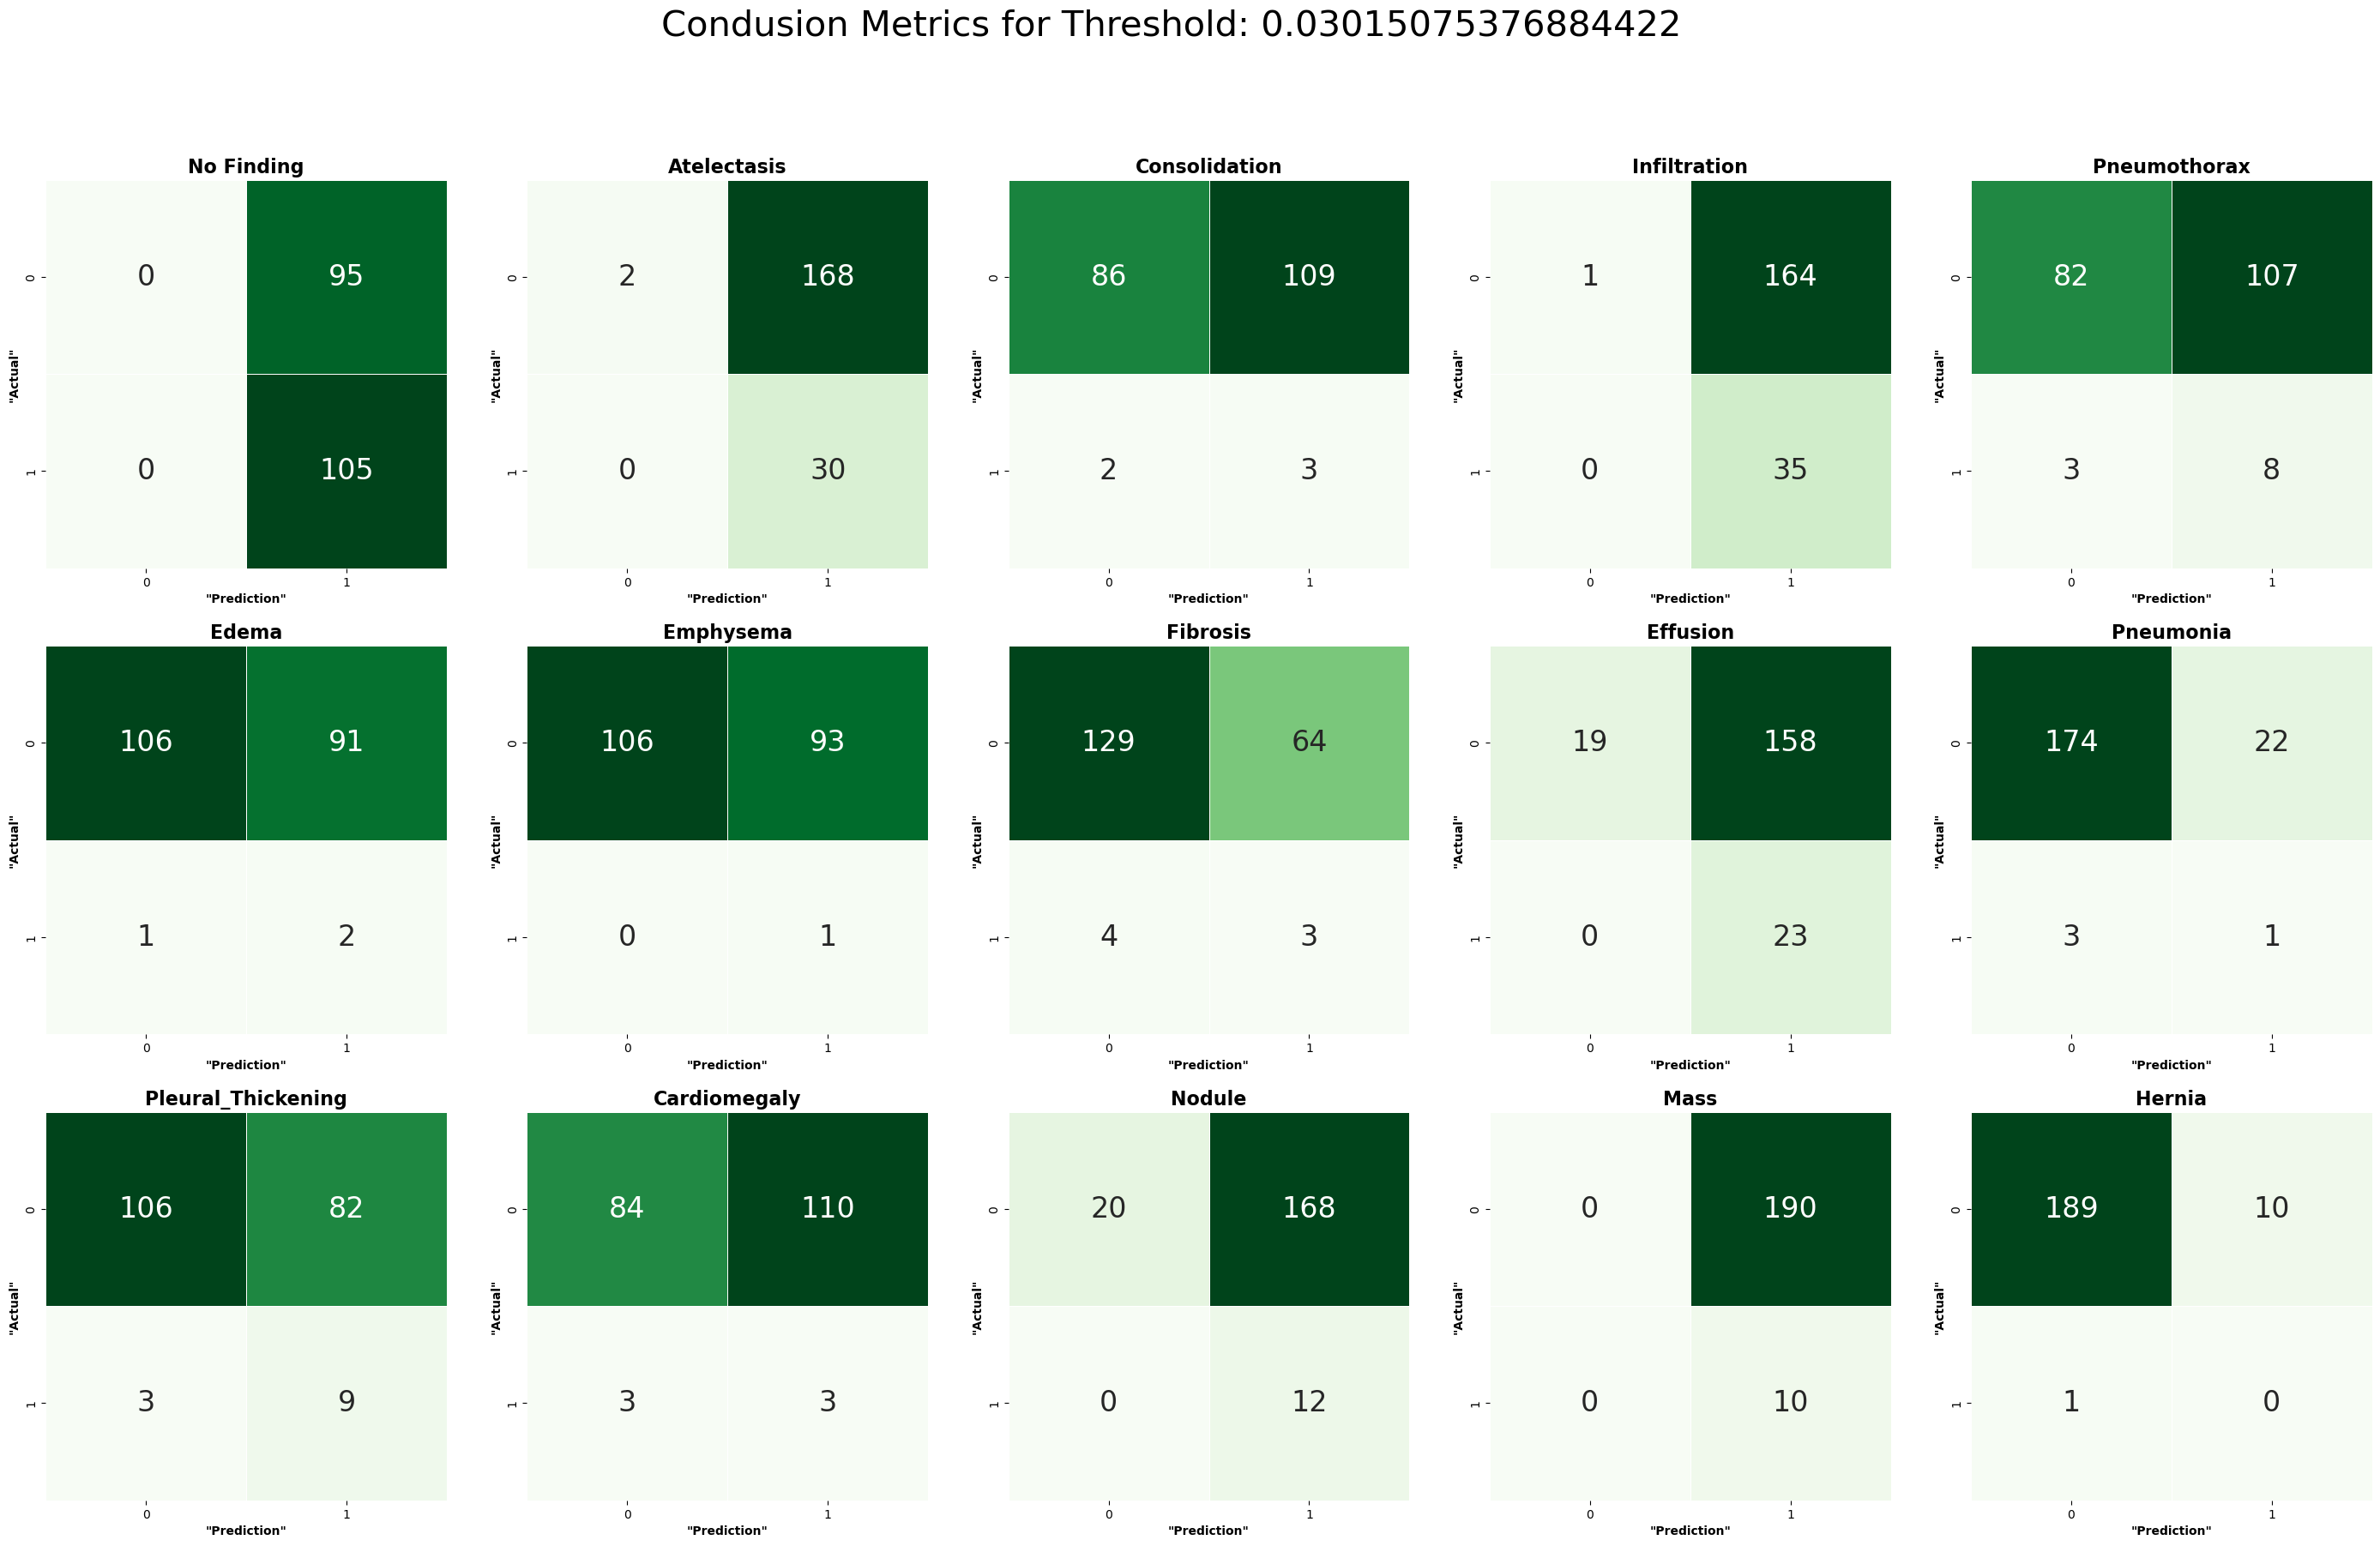

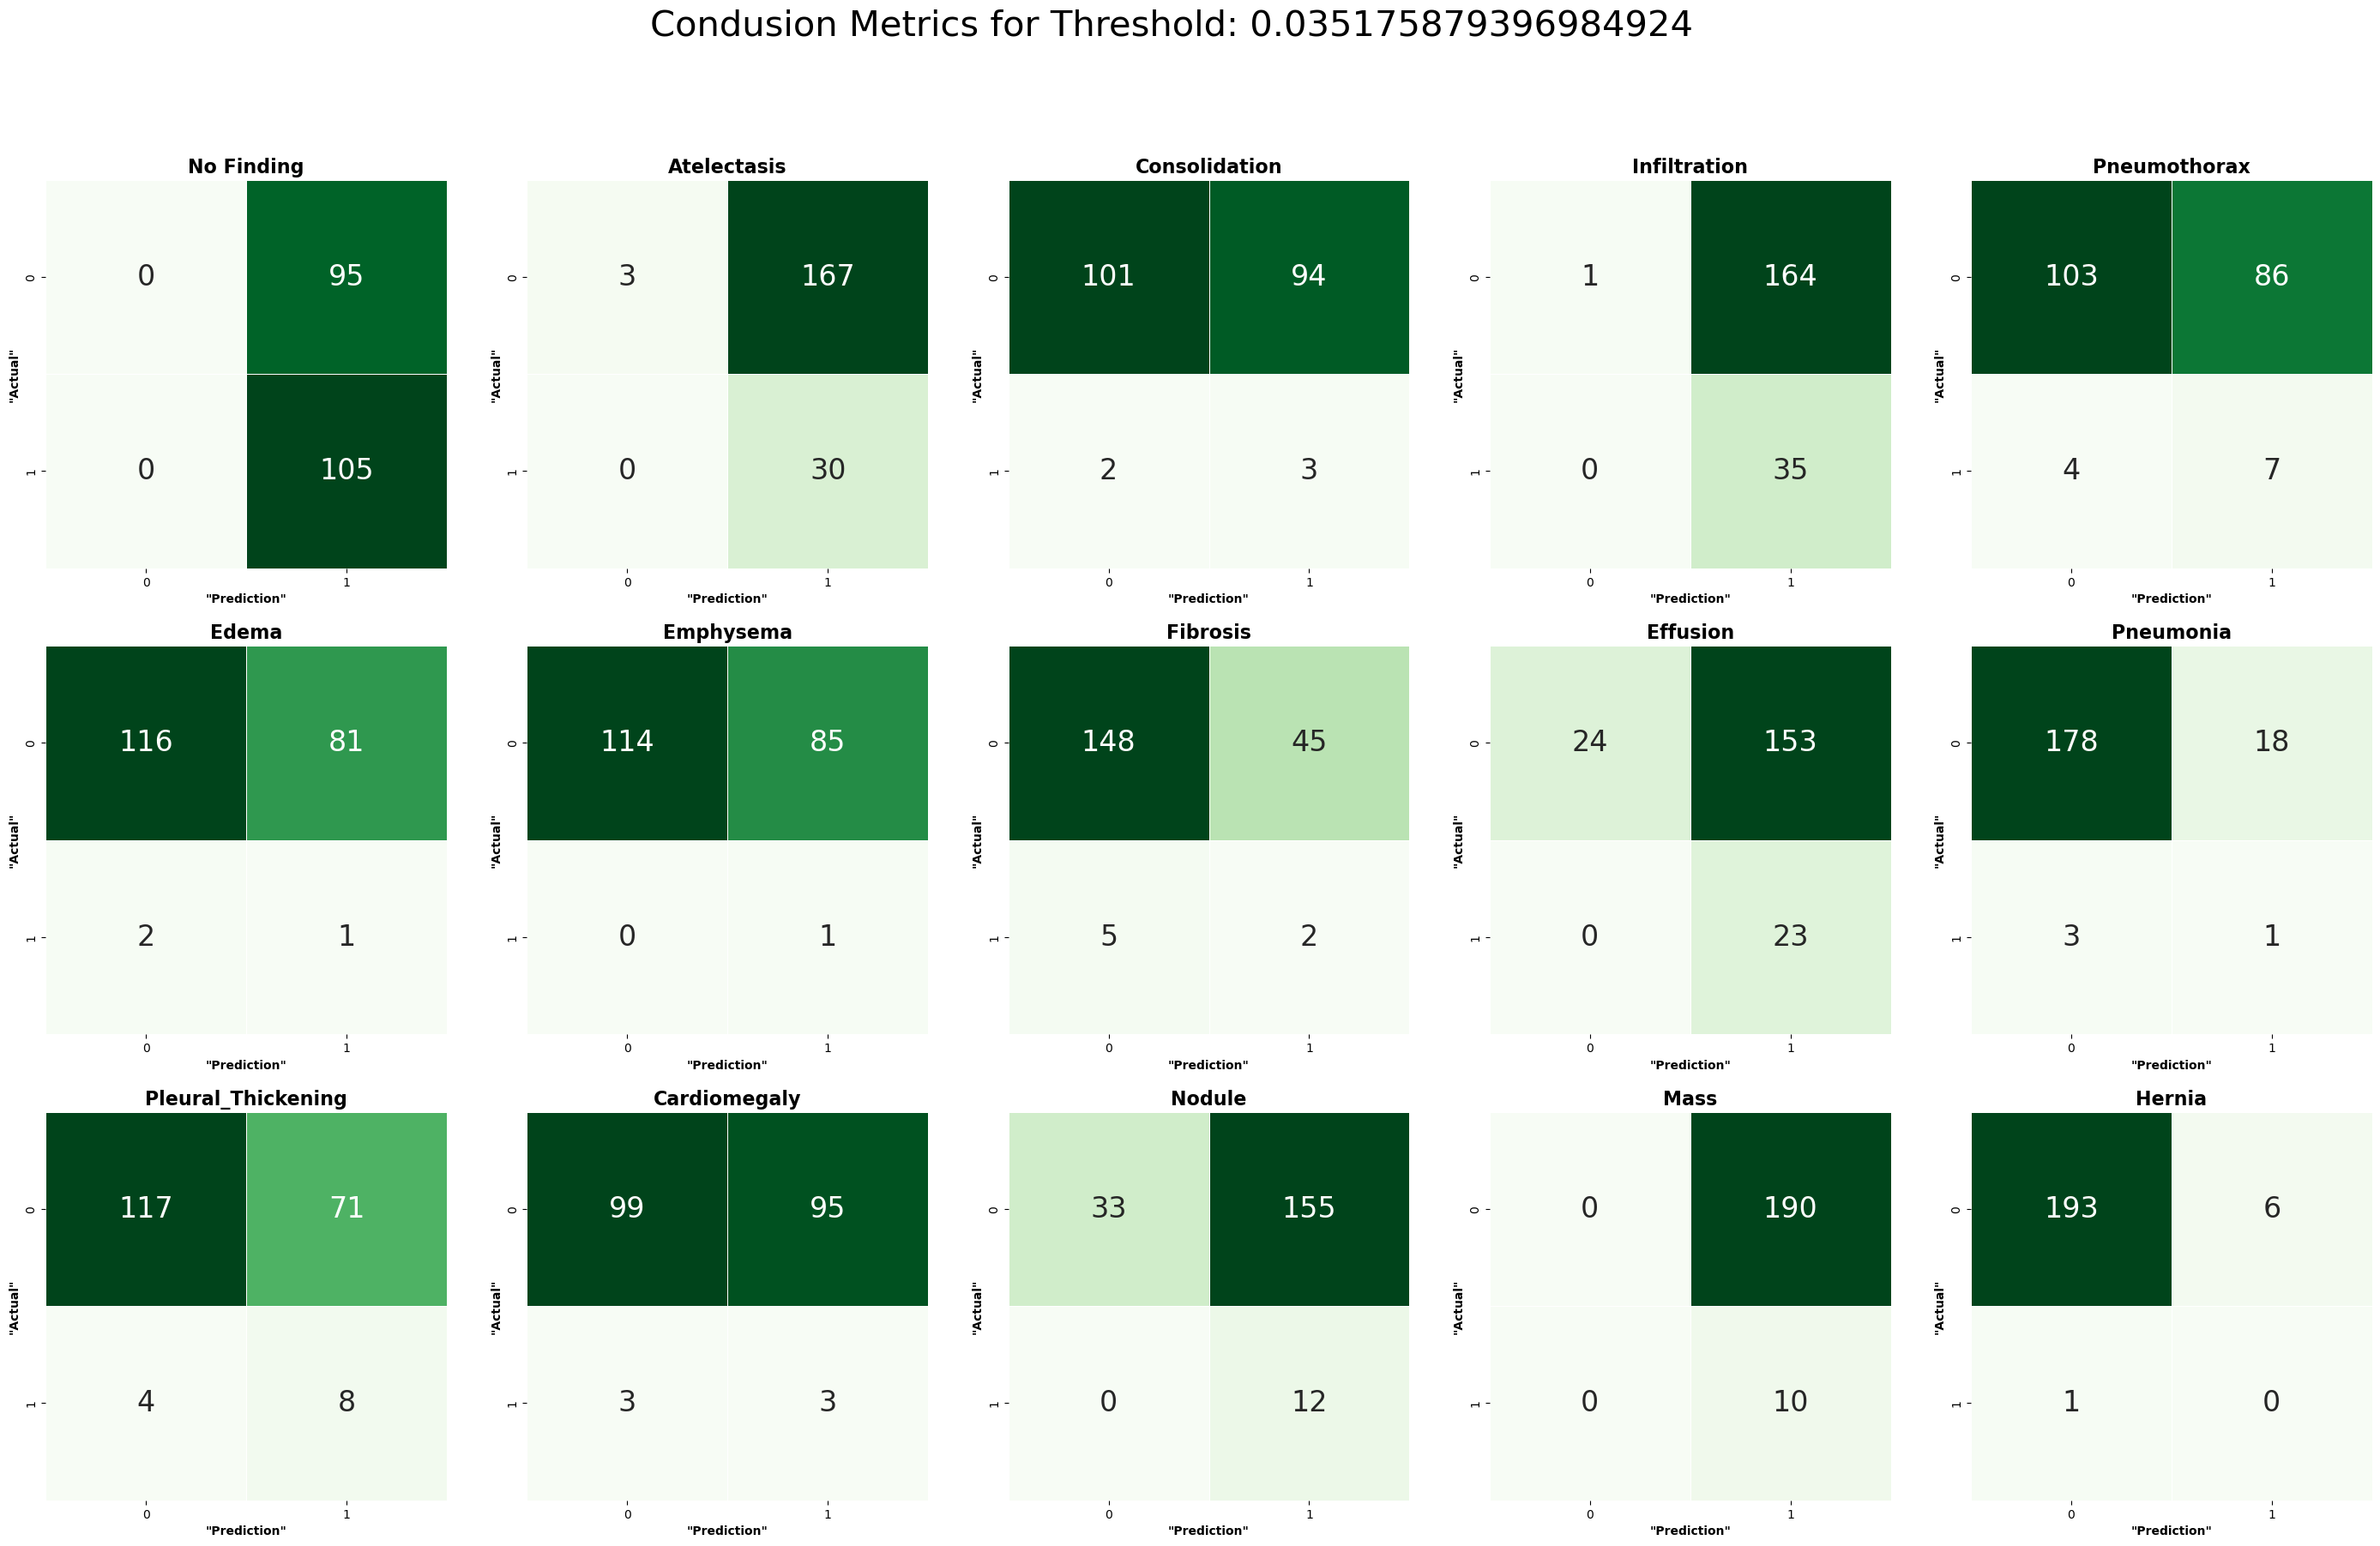

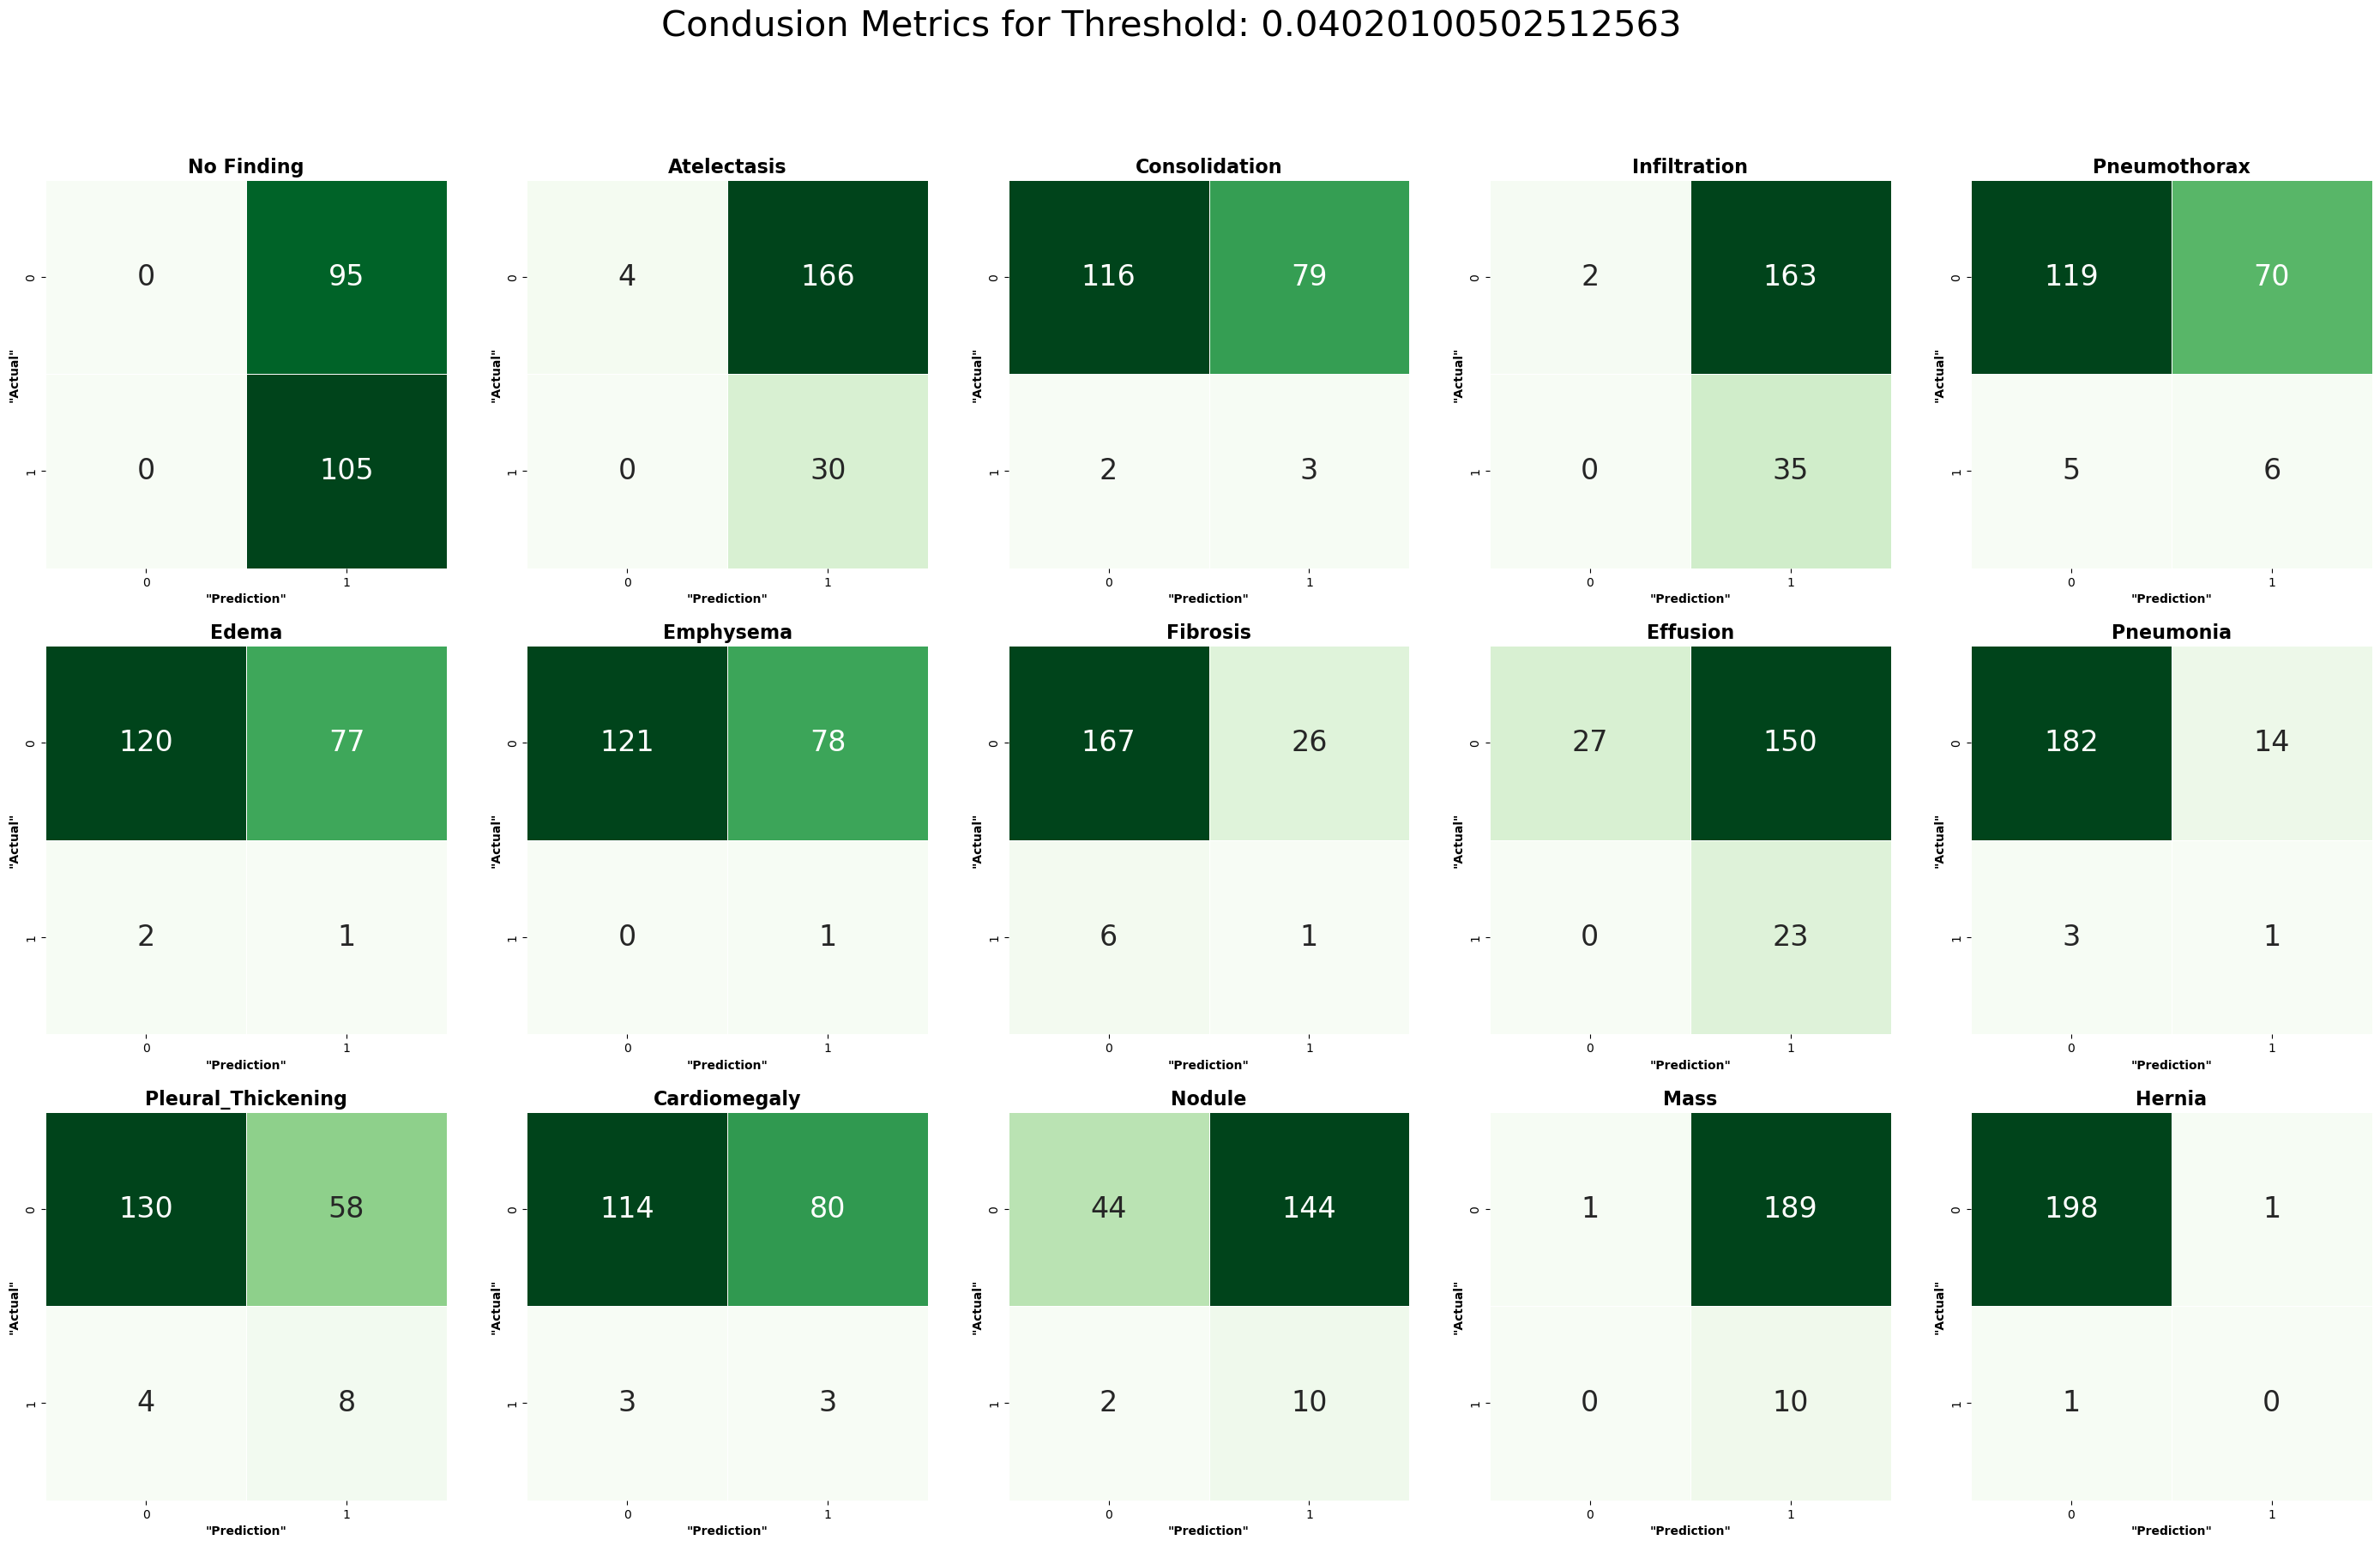

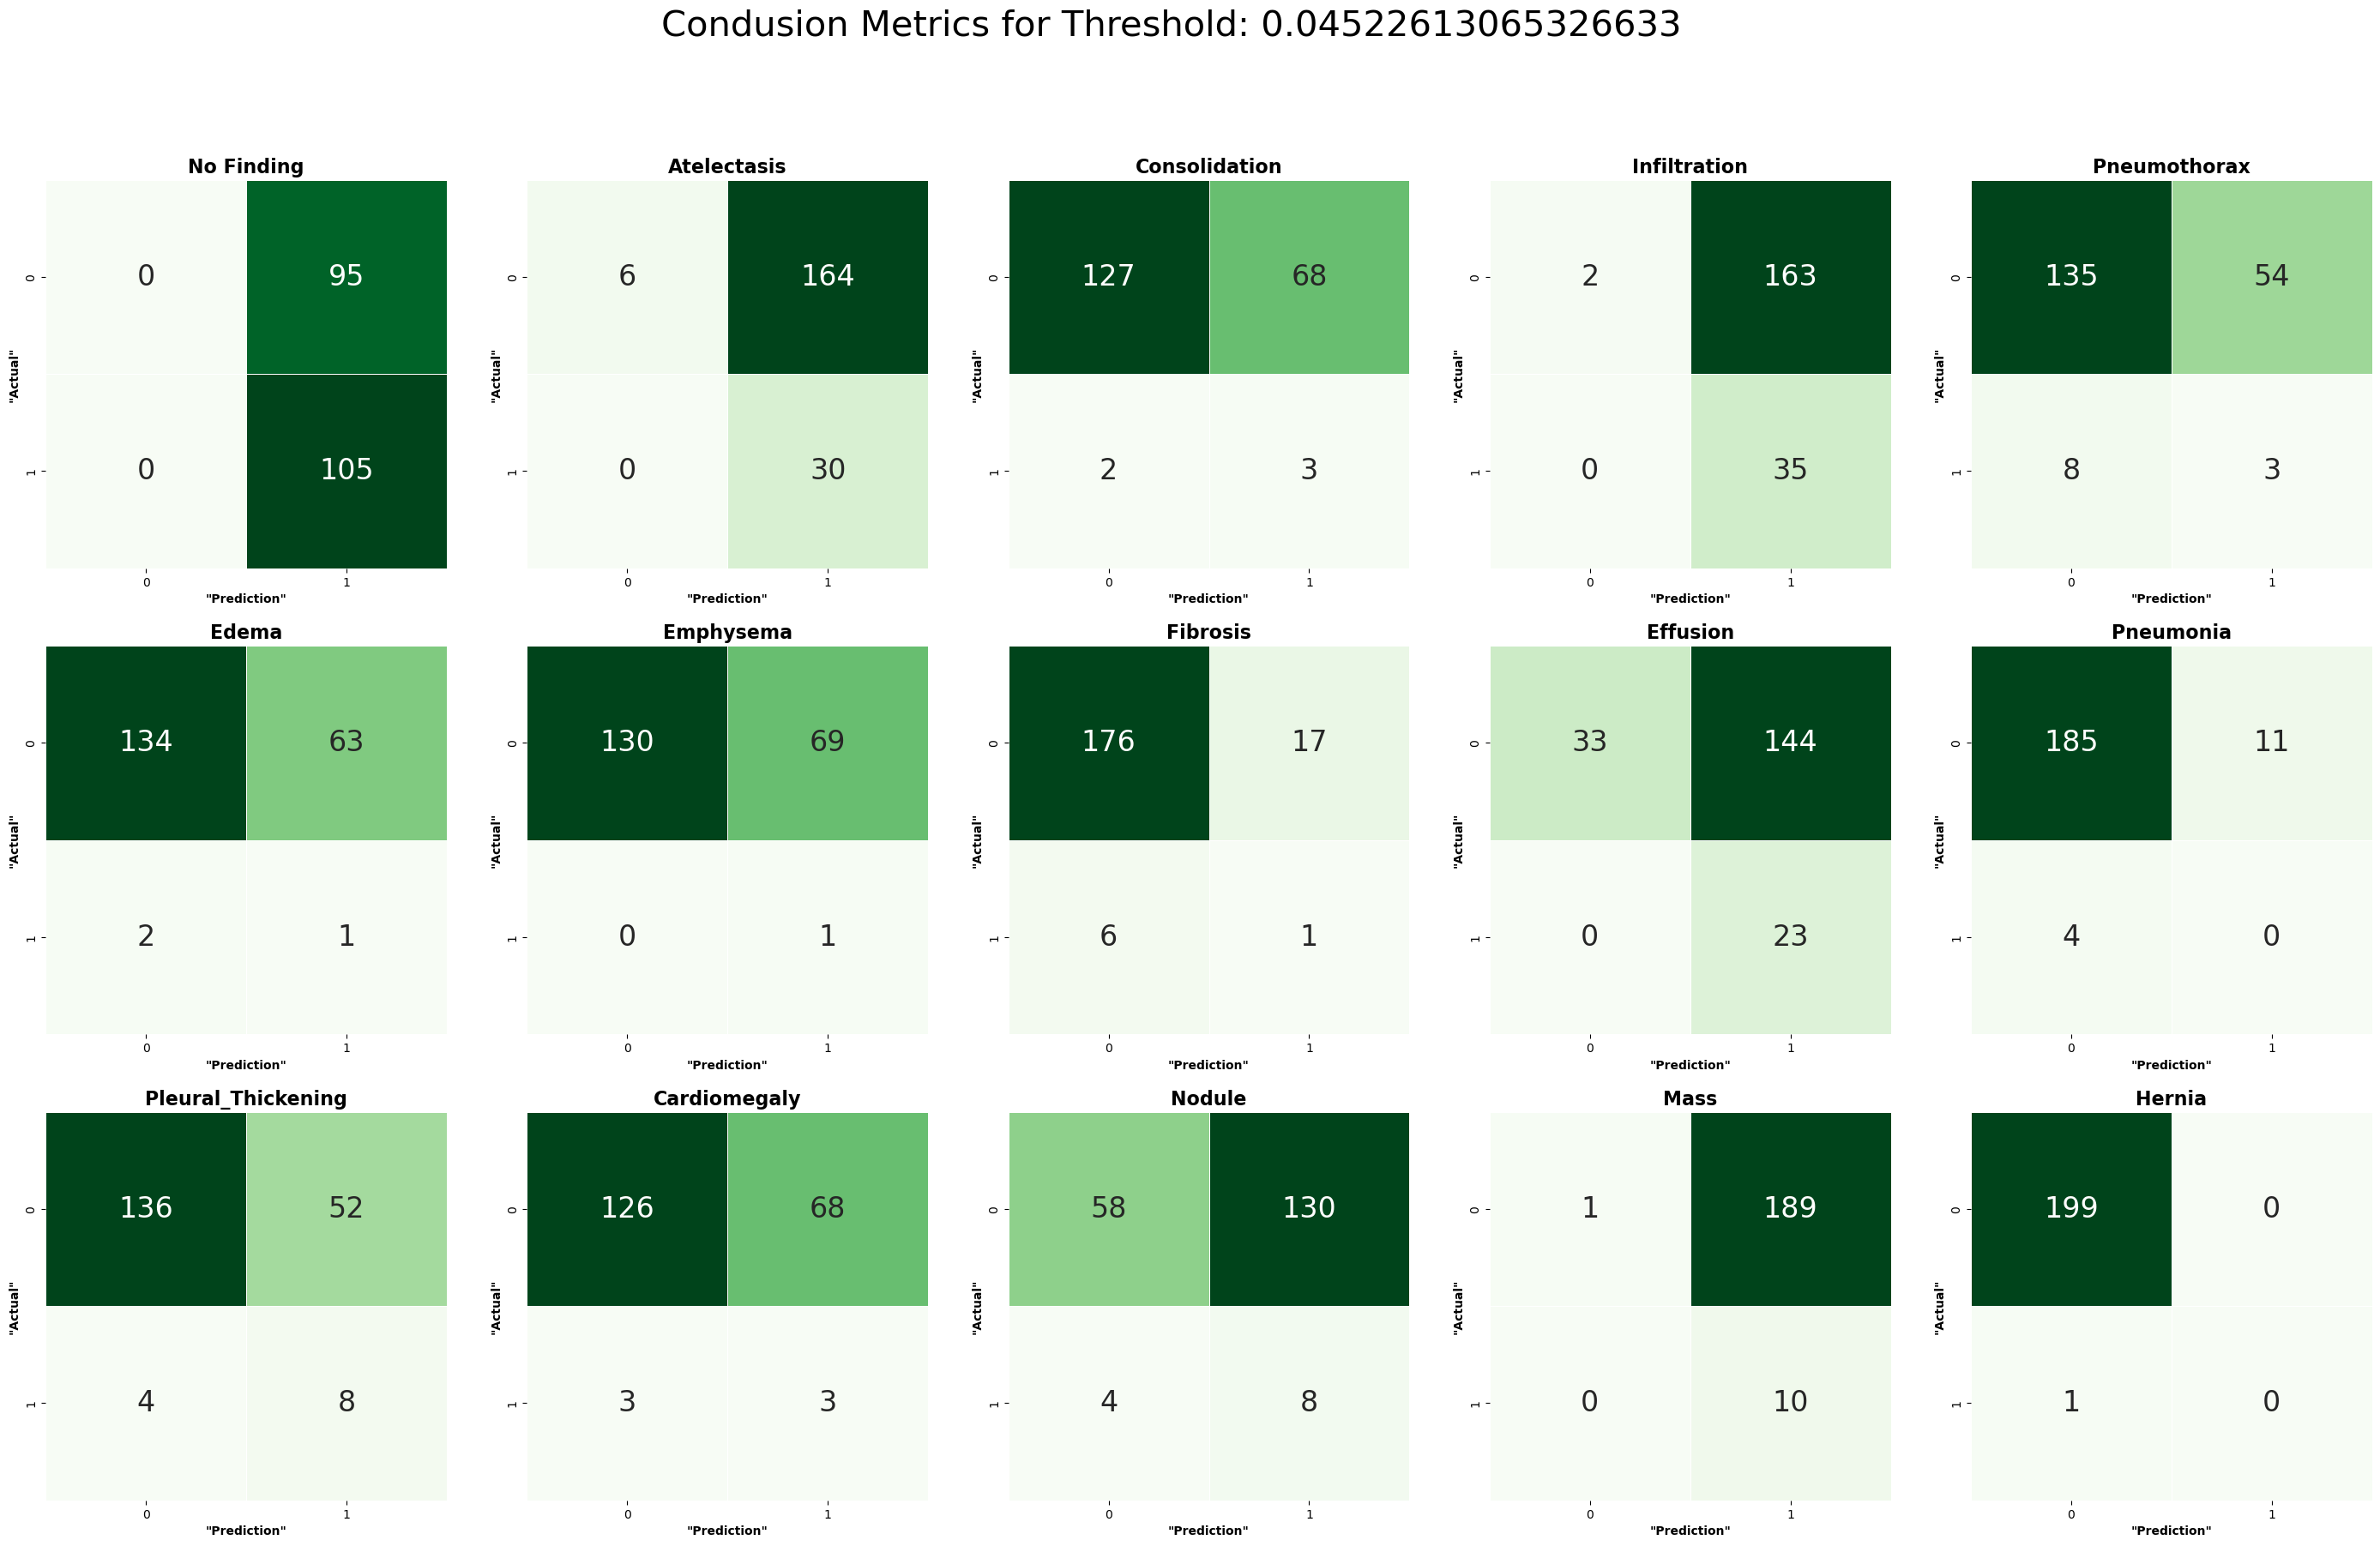

In [13]:
import tensorflow_addons as tfa

for thresh_value in thresholds[:10]:
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true, 
                        (y_preds > thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()